# Lorenz

Importando bibliotecas

In [ ]:
import keras
import numpy as np
from scipy import integrate

2023-06-07 15:34:21.891671: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-07 15:34:21.923314: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-07 15:34:21.923763: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-07 15:34:22.522263: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Definindo EDO de Lorenz, gerando dados de entrada e saída para treinamento da Rede FeedForward

In [ ]:
dt = 0.01; T = 8; t = np.arange(0, T + dt, dt)
beta = 8/3; sigma = 10; rho = 28

nn_input = np.zeros((100 *(len(t) - 1), 3))
nn_output = np.zeros_like(nn_input)

def lorenz_deriv(x_y_z, t0, sigma=sigma, beta=beta, rho=rho):
  x, y, z = x_y_z
  return [sigma*(y-x), x*(rho-z)-y, x*y-beta*z]

x0 = -15 + 30 * np.random.random((100, 3))
x_t = np.asarray([integrate.odeint(lorenz_deriv, x0_j, t) for x0_j in x0])
for j in range(100):
  nn_input[j * (len(t) - 1) : (j + 1) * (len(t) - 1), :] = x_t[j, :-1, :]
  nn_output[j * (len(t) - 1) : (j + 1) * (len(t) - 1), :] = x_t[j, 1:, :]

Preparando modelo de rede neural

In [ ]:
net = keras.models.Sequential()
net.add(keras.layers.Dense(10, input_dim = 3, activation = "sigmoid"))
net.add(keras.layers.Dense(10, activation = "relu"))
net.add(keras.layers.Dense(3, activation = "linear"))
# Use batch size of the same size as the entries in nn_input
# Full batch size
net.compile(loss = "mse", optimizer = "adam")

2023-06-07 15:34:25.965867: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-07 15:34:25.966269: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Realizando treinamento da rede

In [ ]:
%%time
History = net.fit(nn_input, nn_output, epochs = 1000, batch_size = 800)

Epoch 1/1000
100/100 [==============================] - 0s 737us/step - loss: 279.9795
Epoch 2/1000
100/100 [==============================] - 0s 648us/step - loss: 253.5111
Epoch 3/1000
100/100 [==============================] - 0s 639us/step - loss: 209.8714
Epoch 4/1000
100/100 [==============================] - 0s 655us/step - loss: 152.5139
Epoch 5/1000
100/100 [==============================] - 0s 662us/step - loss: 106.7172
Epoch 6/1000
100/100 [==============================] - 0s 787us/step - loss: 80.2434
Epoch 7/1000
100/100 [==============================] - 0s 671us/step - loss: 63.9933
Epoch 8/1000
100/100 [==============================] - 0s 671us/step - loss: 49.4016
Epoch 9/1000
100/100 [==============================] - 0s 645us/step - loss: 34.7266
Epoch 10/1000
100/100 [==============================] - 0s 640us/step - loss: 25.4672
Epoch 11/1000
100/100 [==============================] - 0s 614us/step - loss: 20.4794
Epoch 12/1000
100/100 [========================

Testando rede treinada

In [ ]:
u_trajs = np.zeros((3, len(t), 3))
u_trajs[:, 0, :] = - 15 + 30 * np.random.rand(3, 3)
u_trajs[0, :, :] = integrate.odeint(lorenz_deriv, u_trajs[0, 0, :], t)
u_trajs[1, :, :] = integrate.odeint(lorenz_deriv, u_trajs[1, 0, :], t)
u_trajs[2, :, :] = integrate.odeint(lorenz_deriv, u_trajs[2, 0, :], t)
predicted = np.zeros_like(u_trajs)
predicted[:, 0, :] = u_trajs[:, 0, :]
for j in range(1, len(t)):
    predicted[:, j, :] = net.predict(predicted[:, j - 1, :])



1/1 [==============================] - 0s 13ms/step


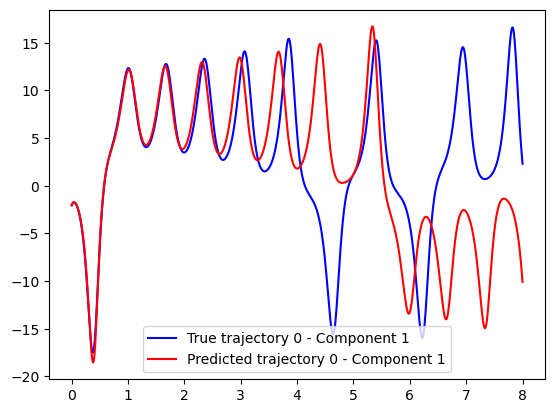

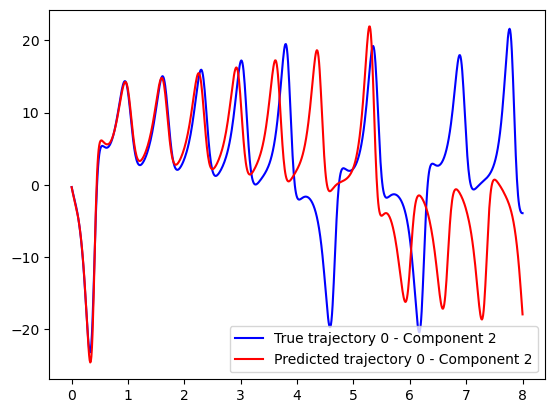

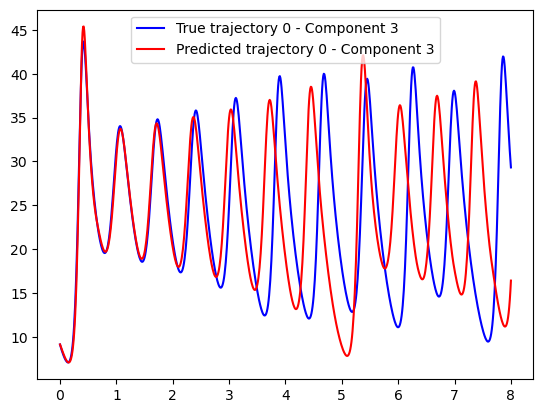

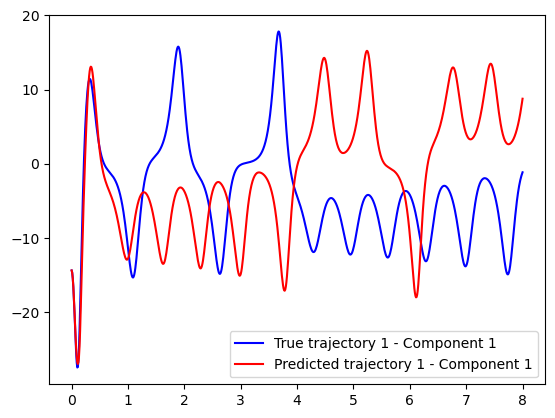

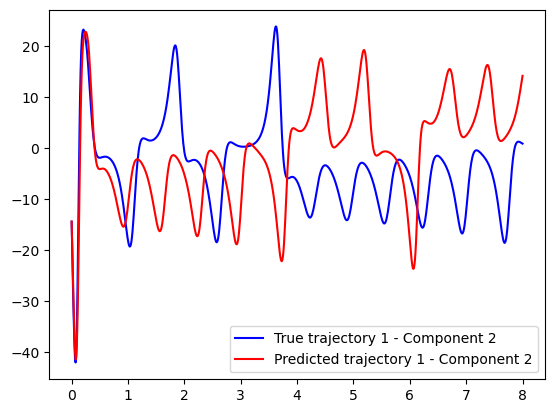

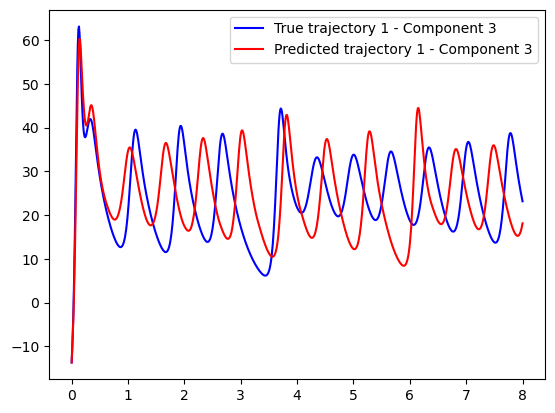

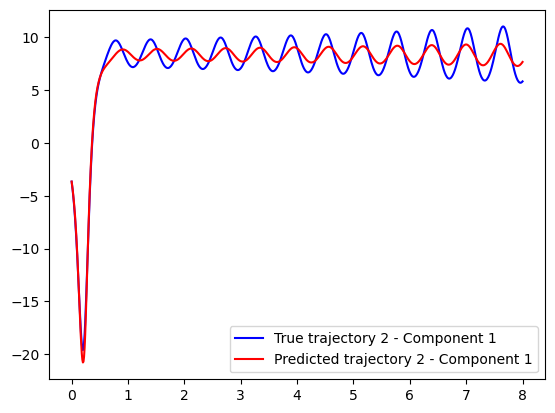

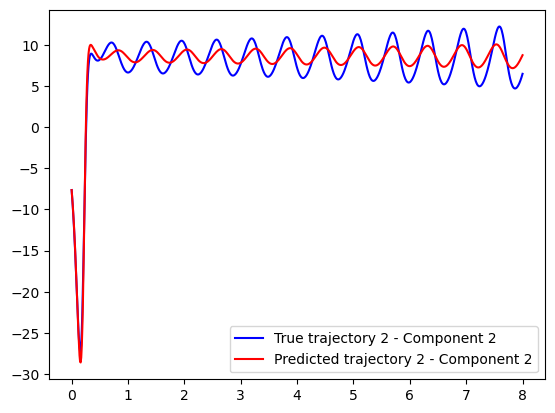

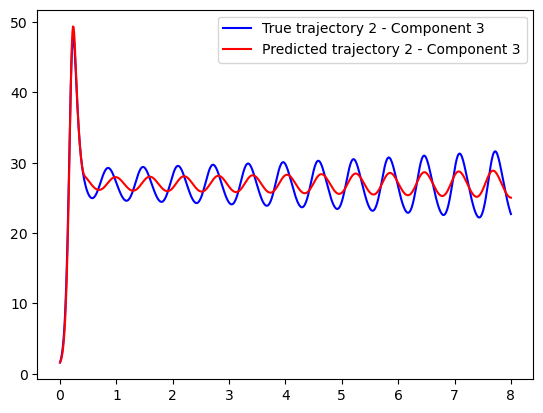

<Figure size 640x480 with 0 Axes>

In [ ]:
from matplotlib import pyplot as plt
# Print each component of the trajectory
for i in range(3):
    for j in range(3):
        plt.plot(t, u_trajs[i, :, j], "b", label = f"True trajectory {i} - Component {j + 1}")
        plt.plot(t, predicted[i, :, j], "r", label = f"Predicted trajectory {i} - Component {j + 1}")
        plt.legend()
        plt.show()
        # Reset
        plt.clf()

Realizando o mesmo teste com condições iniciais mais controladas

In [ ]:
u_trajs = np.zeros((3, len(t), 3))
u_trajs[:, 0, :] = - 15 + 15 * np.random.rand(3, 3)
u_trajs[0, :, :] = integrate.odeint(lorenz_deriv, u_trajs[0, 0, :], t)
u_trajs[1, :, :] = integrate.odeint(lorenz_deriv, u_trajs[1, 0, :], t)
u_trajs[2, :, :] = integrate.odeint(lorenz_deriv, u_trajs[2, 0, :], t)
predicted = np.zeros_like(u_trajs)
predicted[:, 0, :] = u_trajs[:, 0, :]
for j in range(1, len(t)):
    predicted[:, j, :] = net.predict(predicted[:, j - 1, :])

1/1 [==============================] - 0s 12ms/step


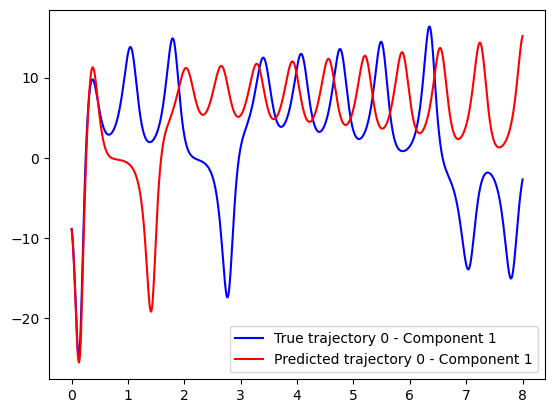

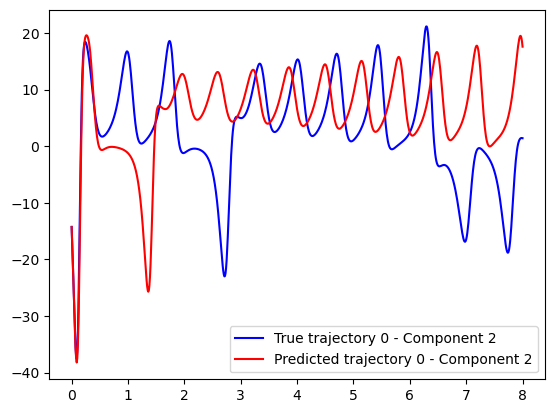

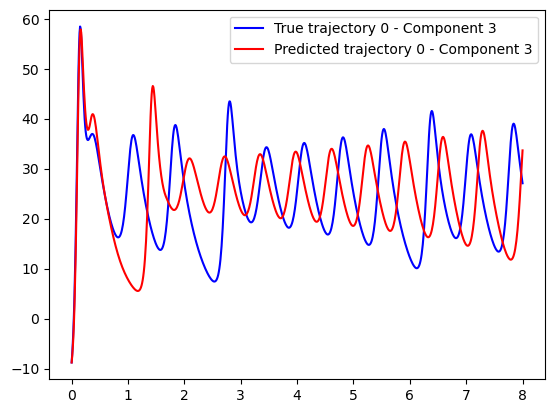

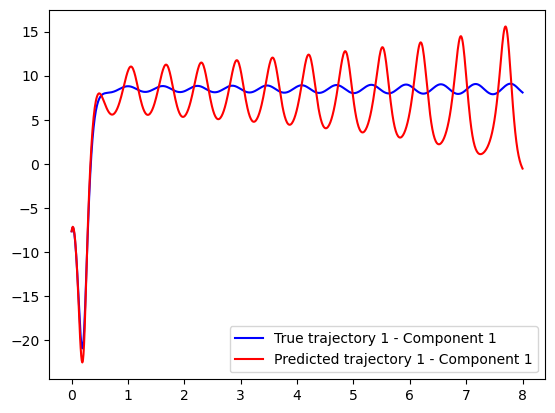

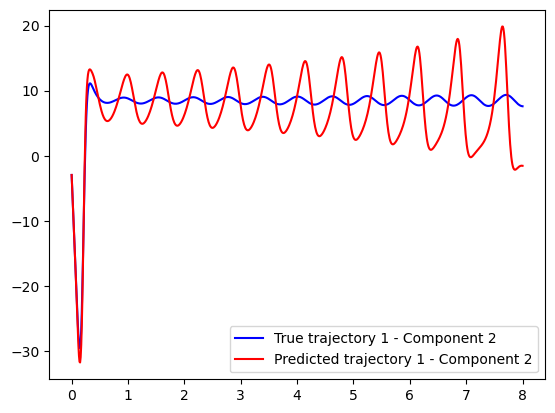

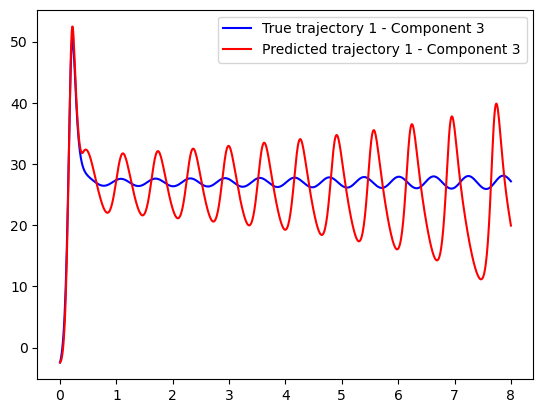

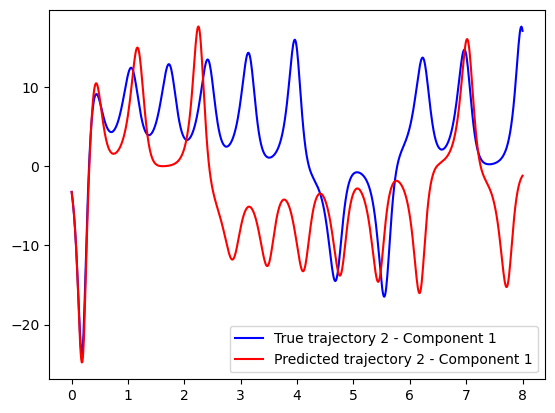

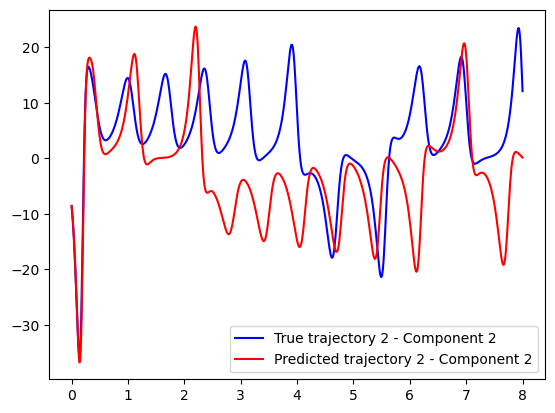

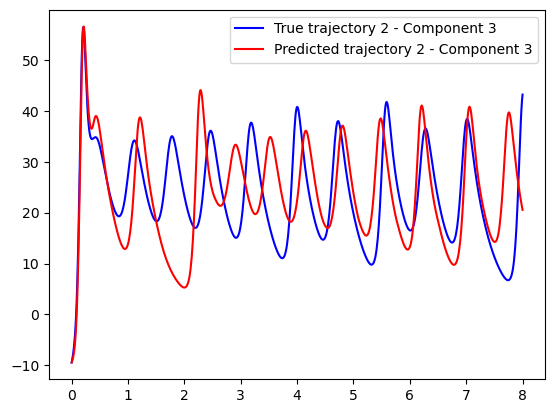

<Figure size 640x480 with 0 Axes>

In [ ]:
from matplotlib import pyplot as plt
# Print each component of the trajectory
for i in range(3):
    for j in range(3):
        plt.plot(t, u_trajs[i, :, j], "b", label = f"True trajectory {i} - Component {j + 1}")
        plt.plot(t, predicted[i, :, j], "r", label = f"Predicted trajectory {i} - Component {j + 1}")
        plt.legend()
        plt.show()
        # Reset
        plt.clf()

# Lotka-Volterra

Importando bibliotecas

In [ ]:
import keras
import numpy as np
from scipy import integrate

2023-06-08 19:07:41.751287: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-08 19:07:42.176465: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-08 19:07:42.177769: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-08 19:07:43.396182: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Parâmetros da simulação e treinamento

Intervalo de integração

In [ ]:
T = 20; dt = 0.01; t = np.arange(0, T + dt, dt)

Constantes do Sistema de EDOs

In [ ]:
alpha = 1; beta = 1.5; gamma = 3; delta = 1

Definindo função que calcula o sistema de EDOs

In [ ]:
def lotka_volterra(x_y, t0):
    x, y = x_y
    return [alpha * x - beta * x * y, delta * x * y - gamma * y]

Quantidade de sistemas utilizados no treinamento

In [ ]:
n = 500

## Gerando dados de treinamento

n Valores iniciais aleatórios

In [ ]:
x0 = 0.5 + 1.5 * np.random.random((n, 2))

Obtendo soluções dos n sistemas

In [ ]:
x_t = np.asarray([integrate.odeint(lotka_volterra, x0_j, t) for x0_j in x0])

Separando input e output para treinamento

In [ ]:
nn_input = np.zeros((n * (len(t) - 1), 2))
nn_output = np.zeros_like(nn_input)

for j in range(n):
    nn_input[j * (len(t) - 1) : (j + 1) * (len(t) - 1), :] = x_t[j, :-1, :]
    nn_output[j * (len(t) - 1) : (j + 1) * (len(t) - 1), :] = x_t[j, 1:, :]

## Gerando dados de treinamento

n Valores iniciais aleatórios

In [ ]:
x0 = 0.5 + 1.5 * np.random.random((n, 2))

Obtendo soluções dos n sistemas

In [ ]:
x_t = np.asarray([integrate.odeint(lotka_volterra, x0_j, t) for x0_j in x0])

Separando input e output para treinamento

In [ ]:
nn_input = np.zeros((n * (len(t) - 1), 2))
nn_output = np.zeros_like(nn_input)

for j in range(n):
    nn_input[j * (len(t) - 1) : (j + 1) * (len(t) - 1), :] = x_t[j, :-1, :]
    nn_output[j * (len(t) - 1) : (j + 1) * (len(t) - 1), :] = x_t[j, 1:, :]

## Modelando e treinando Rede(/s) Neural(/is)

Primeiro, uma rede neural semelhante ao caso apresentado para o Sistema de Lorenz

In [ ]:
netFirst = keras.models.Sequential()
netFirst.add(keras.layers.Dense(10, input_dim = 2, activation = "sigmoid"))
netFirst.add(keras.layers.Dense(10, activation = "relu"))
netFirst.add(keras.layers.Dense(2, activation = "linear"))
netFirst.compile(loss = "mse", optimizer = "adam")

Segundo, uma rede neural com um menor número de neurônios por camadas

In [ ]:
netSecond = keras.models.Sequential()
netSecond.add(keras.layers.Dense(5, input_dim = 2, activation = "sigmoid"))
netSecond.add(keras.layers.Dense(5, activation = "relu"))
netSecond.add(keras.layers.Dense(2, activation = "linear"))
netSecond.compile(loss = "mse", optimizer = "adam")

Terceiro, uma rede neural com uma camada a menos

In [ ]:
netThird = keras.models.Sequential()
netThird.add(keras.layers.Dense(5, input_dim = 2, activation = "sigmoid"))
netThird.add(keras.layers.Dense(2, activation = "relu"))
netThird.compile(loss = "mse", optimizer = "adam")

Treinando as três redes neurais

In [ ]:
historyFirst = netFirst.fit(nn_input, nn_output, epochs = 1000, batch_size = len(t) - 1)
historySecond = netSecond.fit(nn_input, nn_output, epochs = 1000, batch_size = len(t) - 1)
historyThird = netThird.fit(nn_input, nn_output, epochs = 1000, batch_size = len(t) - 1)

Epoch 1/1000
500/500 [==============================] - 1s 750us/step - loss: 2.4332
Epoch 2/1000
500/500 [==============================] - 0s 725us/step - loss: 0.2300
Epoch 3/1000
500/500 [==============================] - 0s 719us/step - loss: 0.0168
Epoch 4/1000
500/500 [==============================] - 0s 702us/step - loss: 0.0066
Epoch 5/1000
500/500 [==============================] - 0s 703us/step - loss: 0.0036
Epoch 6/1000
500/500 [==============================] - 0s 706us/step - loss: 0.0022
Epoch 7/1000
500/500 [==============================] - 0s 736us/step - loss: 0.0015
Epoch 8/1000
500/500 [==============================] - 0s 704us/step - loss: 0.0011
Epoch 9/1000
500/500 [==============================] - 0s 718us/step - loss: 8.2376e-04
Epoch 10/1000
500/500 [==============================] - 0s 705us/step - loss: 6.4904e-04
Epoch 11/1000
500/500 [==============================] - 0s 755us/step - loss: 5.1854e-04
Epoch 12/1000
500/500 [============================

Abaixo estão os gráficos com o histórico de *loss* para cada Rede Neural. Utilizaremos escala logarítmica devido à grande amplitude de valores.

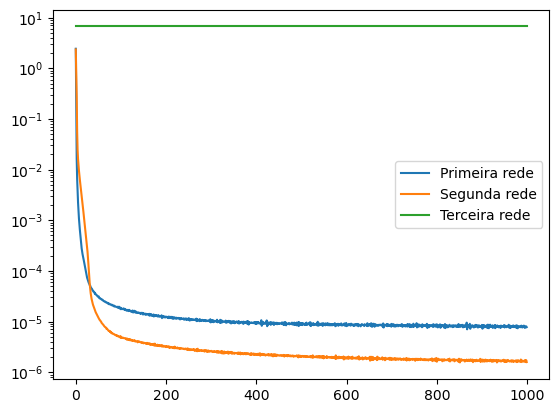

In [ ]:
from matplotlib import pyplot as plt
plt.plot(historyFirst.history["loss"], label = "Primeira rede")
plt.plot(historySecond.history["loss"], label = "Segunda rede")
plt.plot(historyThird.history["loss"], label = "Terceira rede")
plt.yscale("log")
plt.legend()
plt.show()

Como pode ser visto, as duas primeiras redes convergem - a primeira de forma mais rápida que a segunda - enquanto a terceira não atinge convergência.

Uma rede com maior número de neurônios por camada aumenta a capacidade de "tomada de decisão" da rede, geralmente permitindo uma diminuição geral do *loss*.
No entanto, uma rede com um maior número de neurônios perde a capacidade de **generalização**, geralmente causando o *overfitting*, isto é, a incapacidade de realizar boas predições com dados que fogem do padrão dos dados utilizados no treinamento. Apesar disso, a segunda rede atingiu um *loss* final inferior ao da primeira mesmo utilizando um número menor de neurônios.

Portanto, a segunda rede se sai como "vencedora" potencial nesse treinamento.

Antes de prosseguir, podemos tentar novamente diminuir o número de neurônios em uma quarta rede, e observar se a convergência ainda será atingida.

In [ ]:
netFourth = keras.models.Sequential()
netFourth.add(keras.layers.Dense(3, input_dim = 2, activation = "sigmoid"))
netFourth.add(keras.layers.Dense(4, activation = "relu"))
netFourth.add(keras.layers.Dense(2, activation = "linear"))
netFourth.compile(loss = "mse", optimizer = "adam")

In [ ]:
historyFourth = netFourth.fit(nn_input, nn_output, epochs = 1000, batch_size = len(t) - 1)

Epoch 1/1000
500/500 [==============================] - 1s 642us/step - loss: 3.1888
Epoch 2/1000
500/500 [==============================] - 0s 689us/step - loss: 1.0336
Epoch 3/1000
500/500 [==============================] - 0s 641us/step - loss: 0.5007
Epoch 4/1000
500/500 [==============================] - 0s 668us/step - loss: 0.2879
Epoch 5/1000
500/500 [==============================] - 0s 646us/step - loss: 0.1761
Epoch 6/1000
500/500 [==============================] - 0s 649us/step - loss: 0.0274
Epoch 7/1000
500/500 [==============================] - 0s 644us/step - loss: 0.0160
Epoch 8/1000
500/500 [==============================] - 0s 648us/step - loss: 0.0105
Epoch 9/1000
500/500 [==============================] - 0s 655us/step - loss: 0.0074
Epoch 10/1000
500/500 [==============================] - 0s 672us/step - loss: 0.0055
Epoch 11/1000
500/500 [==============================] - 0s 667us/step - loss: 0.0043
Epoch 12/1000
500/500 [==============================] - 0s 638

Vamos agora comparar essa quarta rede neural com as duas primeiras que atingiram convergência. Para melhorar a visualização, dessa vez utilizaremos uma escala logarítmica no eixo y.

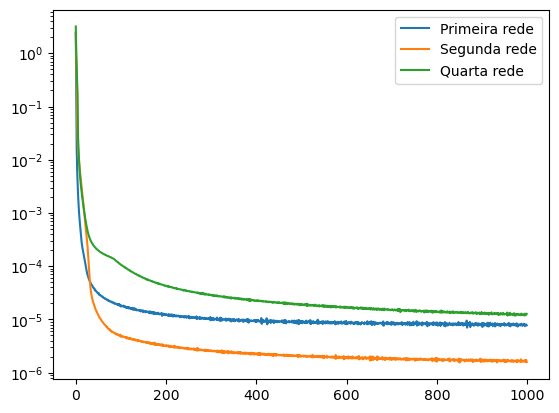

In [ ]:
plt.plot(historyFirst.history["loss"], label = "Primeira rede")
plt.plot(historySecond.history["loss"], label = "Segunda rede")
plt.plot(historyFourth.history["loss"], label = "Quarta rede")
plt.yscale("log")
plt.legend()
plt.show()

A quarta rede não atingiu um *loss* tão baixo quanto o da segunda, mas chegou muito próxima da primeira, com um número muito menor de neurônios. Isso indica a possibilidade dessa rede ser mais generalizável, e obter um resultado ainda efetivo.

## Testando redes neurais treinadas

Iremos gerar 3 condições iniciais, obter o resultado via integração utilizando um método numérico de Runge-Kutta e depois iremos comparar com a predição gerada pelas 3 redes neurais adotadas (primeira, segunda e quarta).
As condições iniciais geradas vão fugir do padrão utilizado em treinamento, para avaliar a capacidade de generalização das redes.

In [ ]:
x0_testing = 0.5 + 3.0 * np.random.random((3, 2))
x_t_testing = np.asarray([integrate.odeint(lotka_volterra, x0_j, t) for x0_j in x0_testing])
predictedFirst = np.zeros_like(x_t_testing) # Primeira rede
predictedSecond = np.zeros_like(x_t_testing) # Segunda rede
predictedFourth = np.zeros_like(x_t_testing) # Quarta rede
predictedFirst[:, 0, :] = x0_testing
predictedSecond[:, 0, :] = x0_testing
predictedFourth[:, 0, :] = x0_testing
for j in range(1, len(t)):
    predictedFirst[:, j, :] = netFirst.predict(predictedFirst[:, j - 1, :])
    predictedSecond[:, j, :] = netSecond.predict(predictedSecond[:, j - 1, :])
    predictedFourth[:, j, :] = netFourth.predict(predictedFourth[:, j - 1, :])

1/1 [==============================] - 0s 13ms/step


## Resultados do teste

Comparando o valor das componentes $x$ e $y$ para as 3 condições iniciais

### Gráfico componentes x tempo

<Figure size 640x480 with 0 Axes>

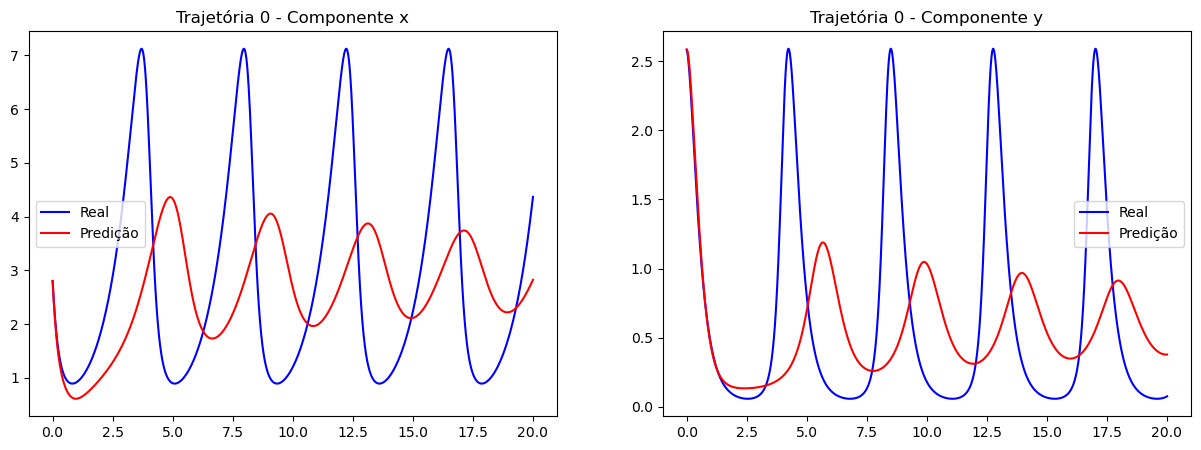

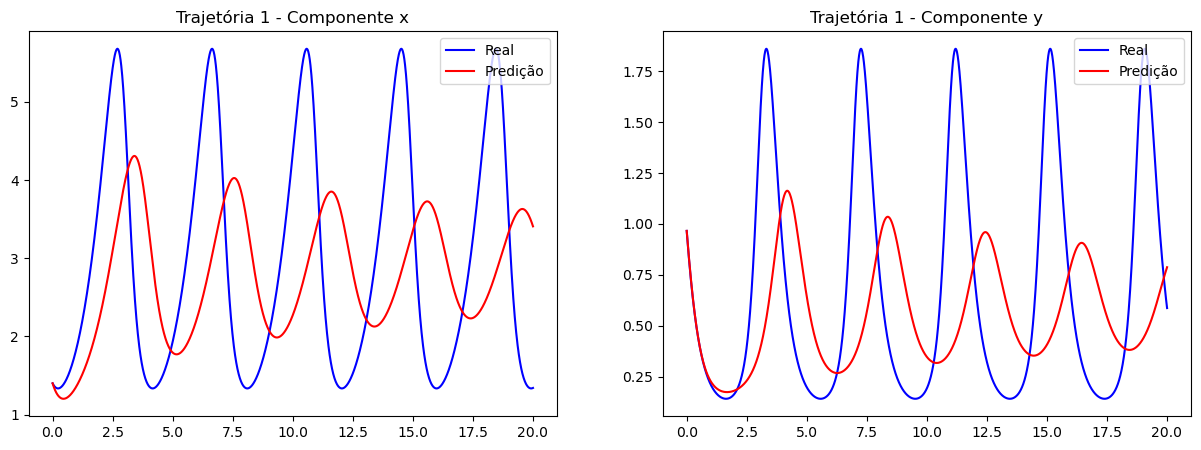

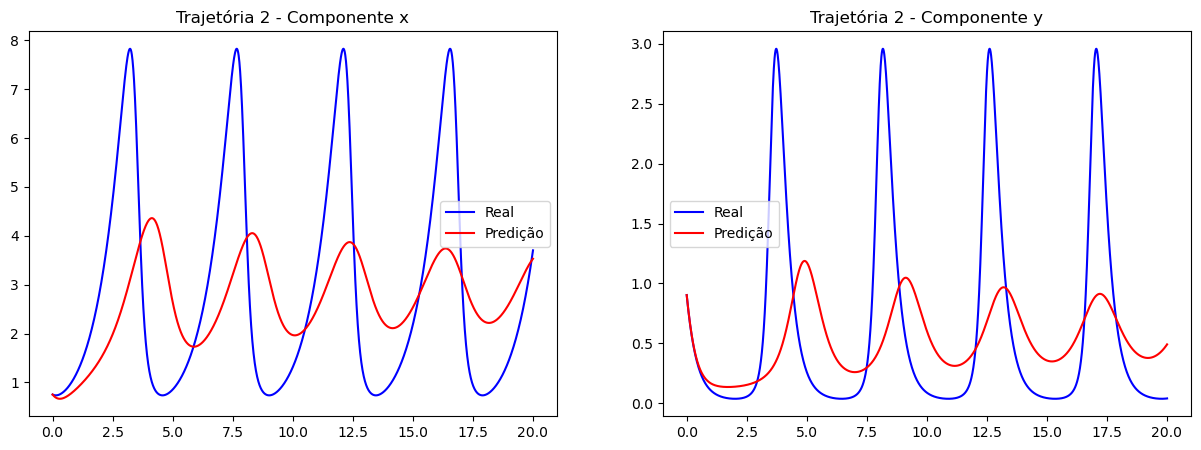

<Figure size 640x480 with 0 Axes>

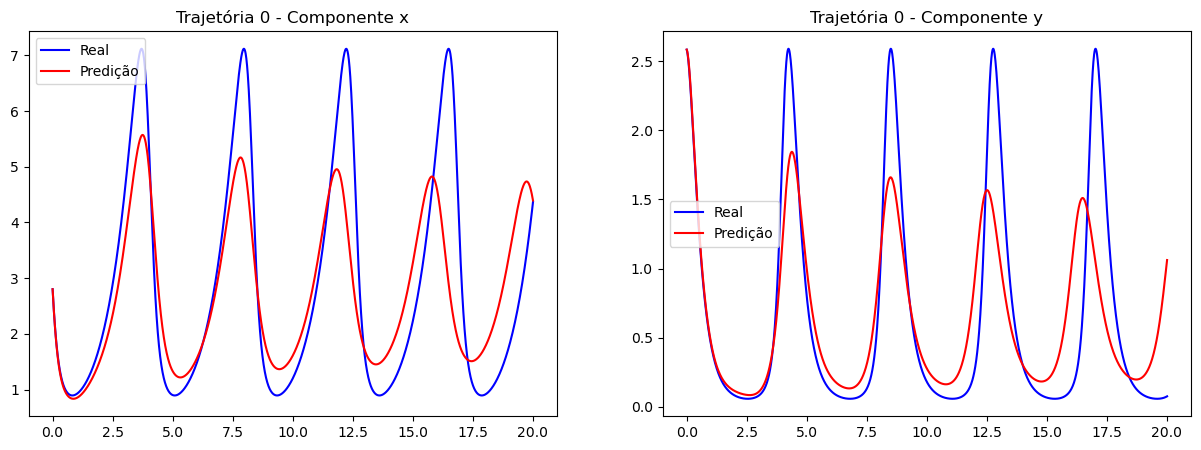

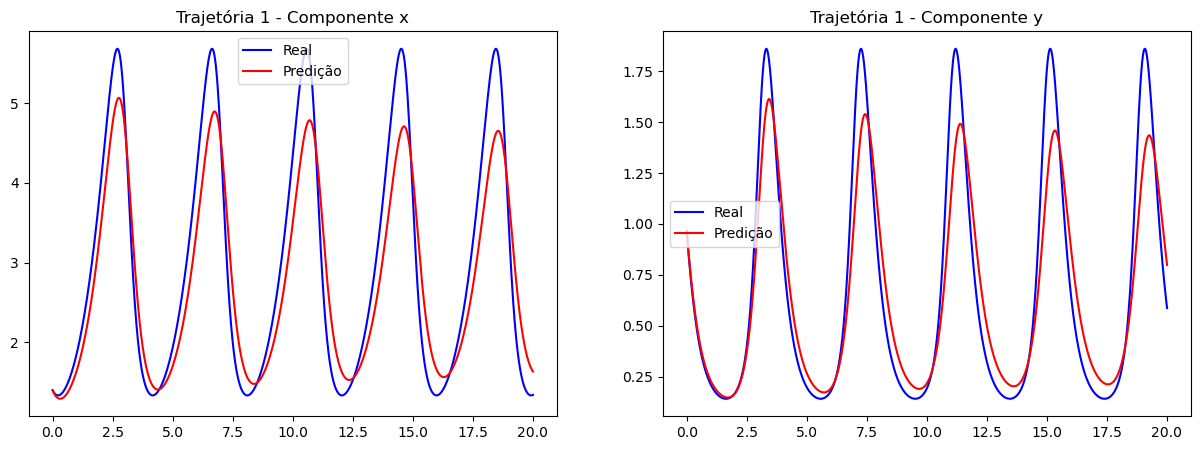

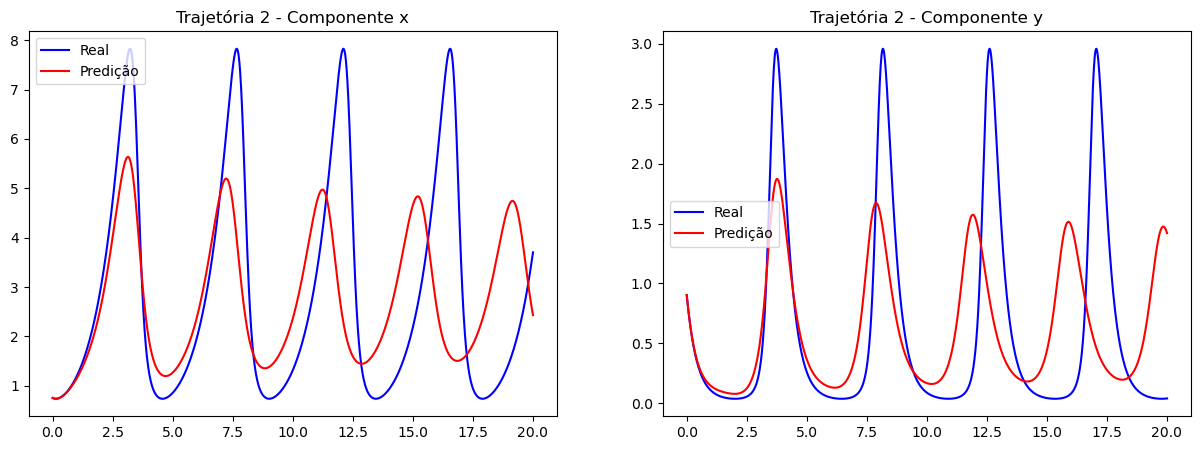

<Figure size 640x480 with 0 Axes>

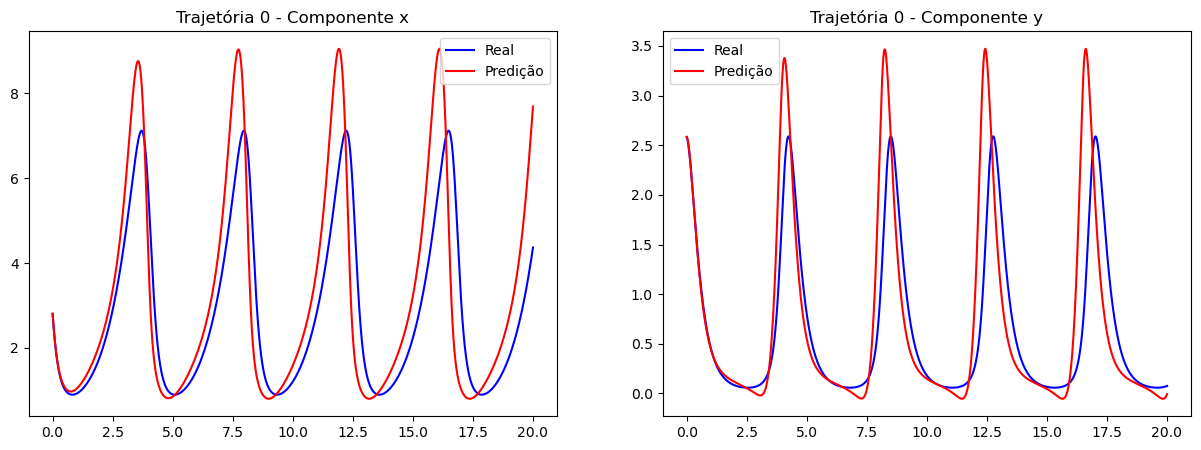

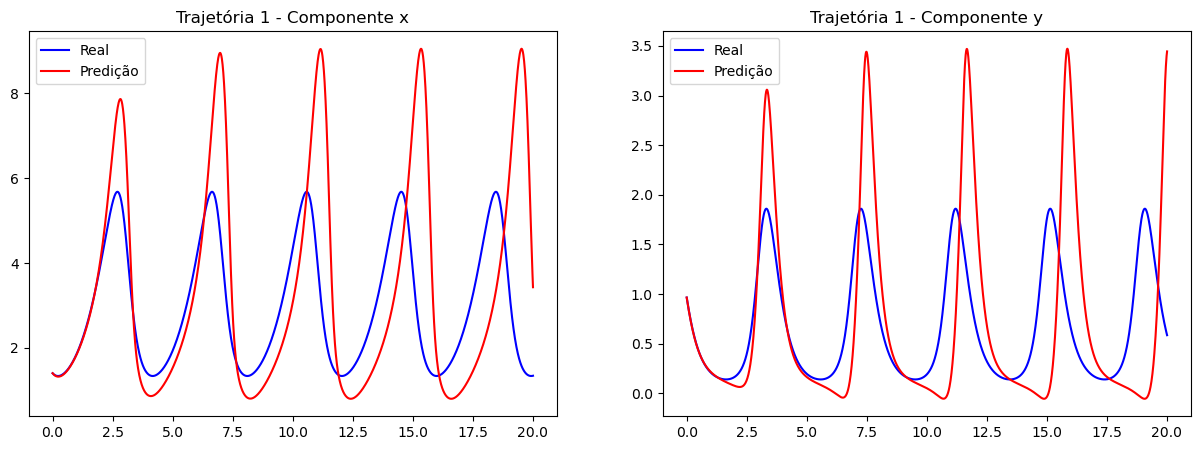

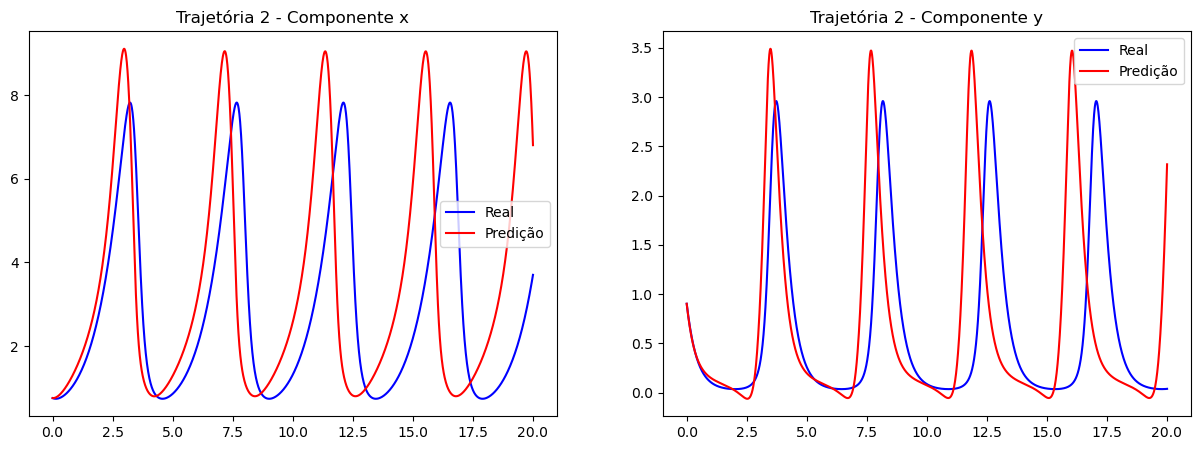

In [ ]:
from matplotlib import pyplot as plt
from IPython.display import display, HTML
components = ["x", "y"]
predictions = [predictedFirst, predictedSecond, predictedFourth]
networks = ["Primeira rede", "Segunda rede", "Quarta rede"]
for i, network in enumerate(networks):
    display(HTML(f"<h1 style='font-size: 64px'>{network}</h1>"), )
    figure = plt.figure()
    for traj in range(3):
        _, axis = plt.subplots(1, 2, figsize = (15, 5))
        for j in range(2):
            axis[j].plot(t, x_t_testing[traj, :, j], "b", label = "Real")
            axis[j].plot(t, predictions[i][traj, :, j], "r", label = "Predição")
            axis[j].legend()
            axis[j].set_title(f"Trajetória {traj} - Componente {components[j]}")
    plt.show()


As duas redes com menos neurônios apresentaram o melhor desempenho, requalificando o que foi dito à respeito da capacidade de generalização das redes e sua proporcionalidade inversa ao número de neurônios.

<span style="color:#A00">Utilizei HTML para renderizar os títulos acima das redes pois a engine do Matplotlib não estava renderizando o título das figuras</span>.

### Gráficos de Phase-Space

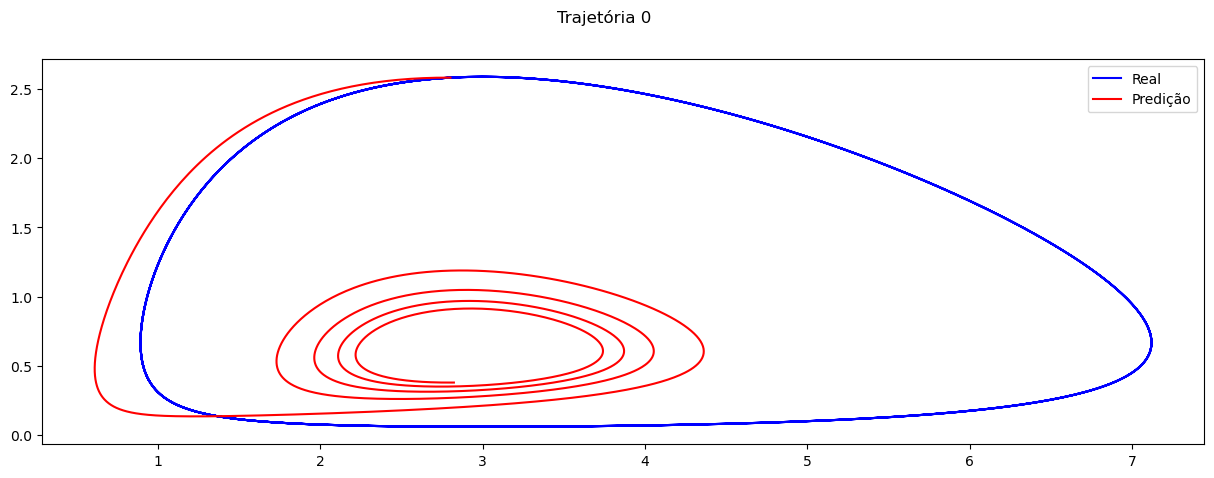

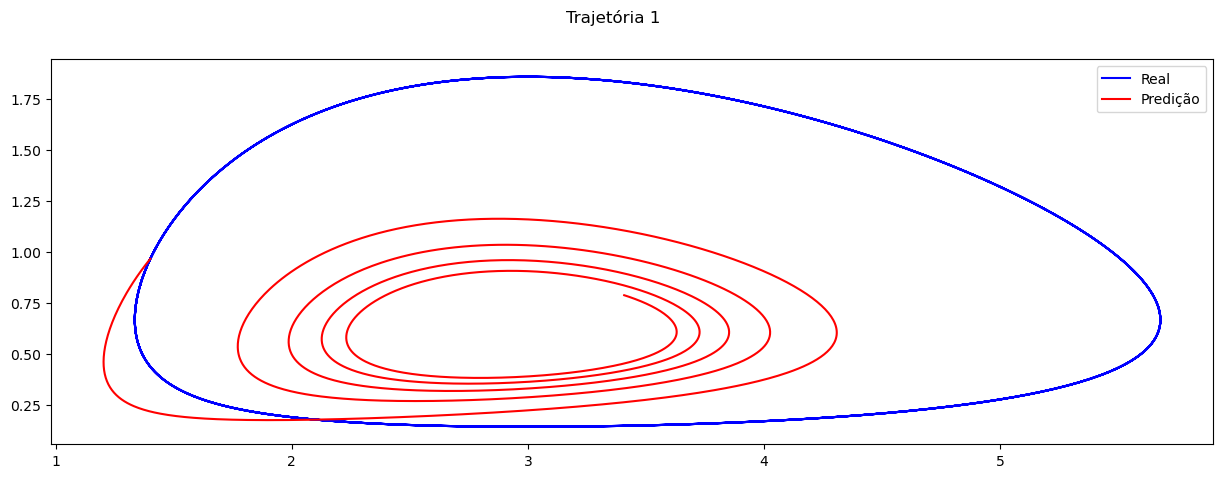

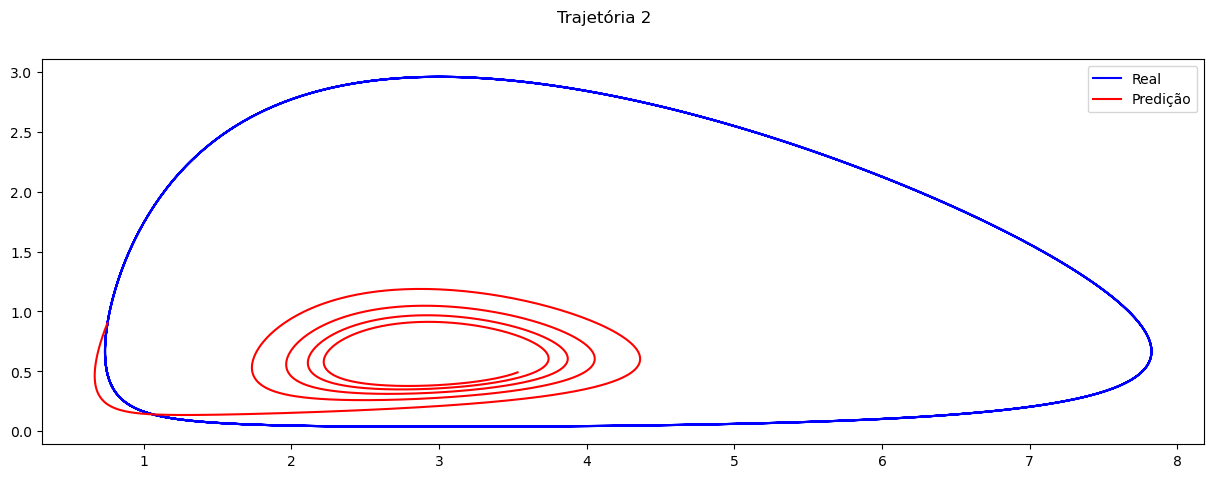

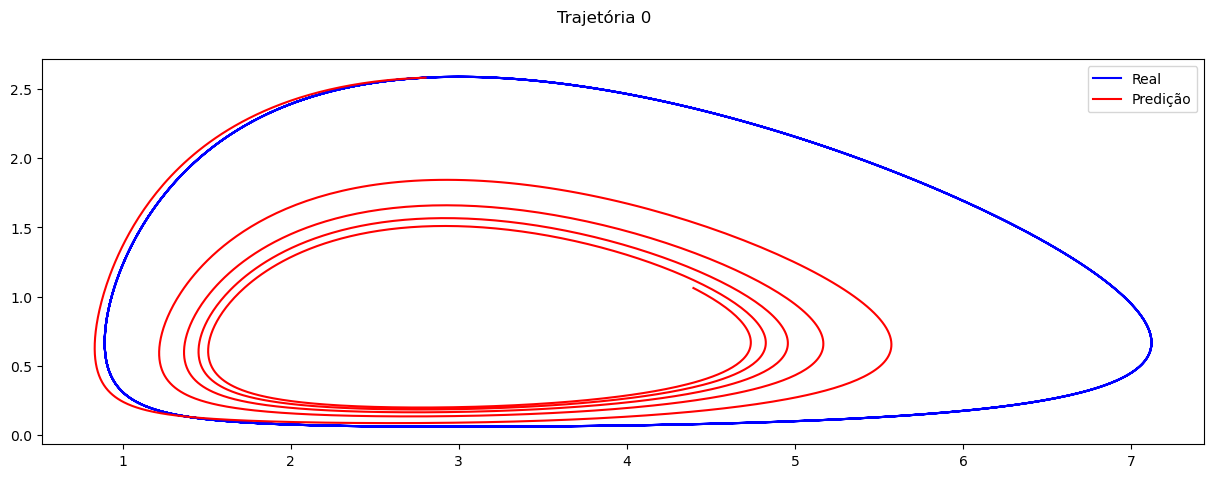

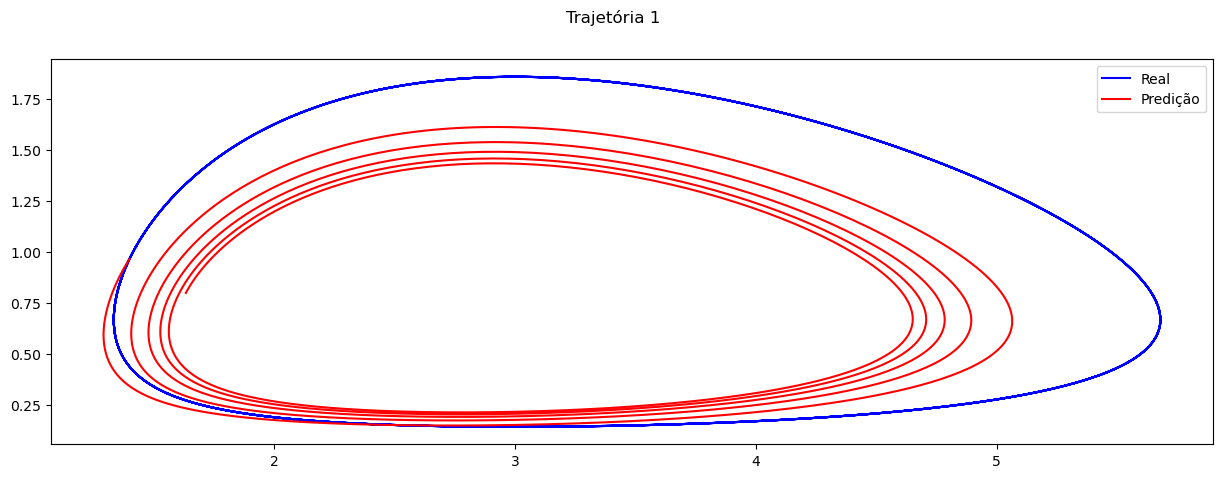

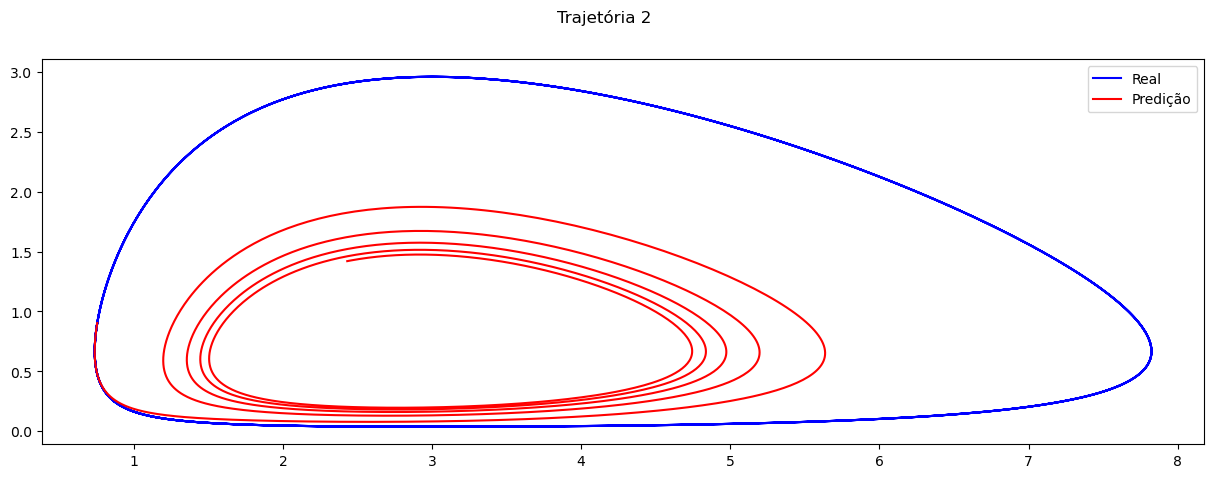

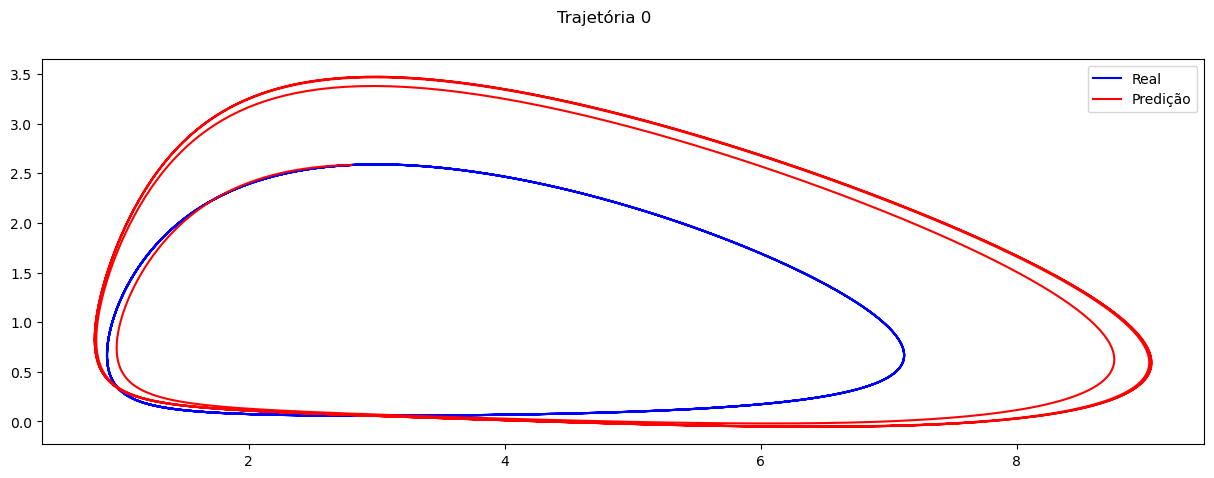

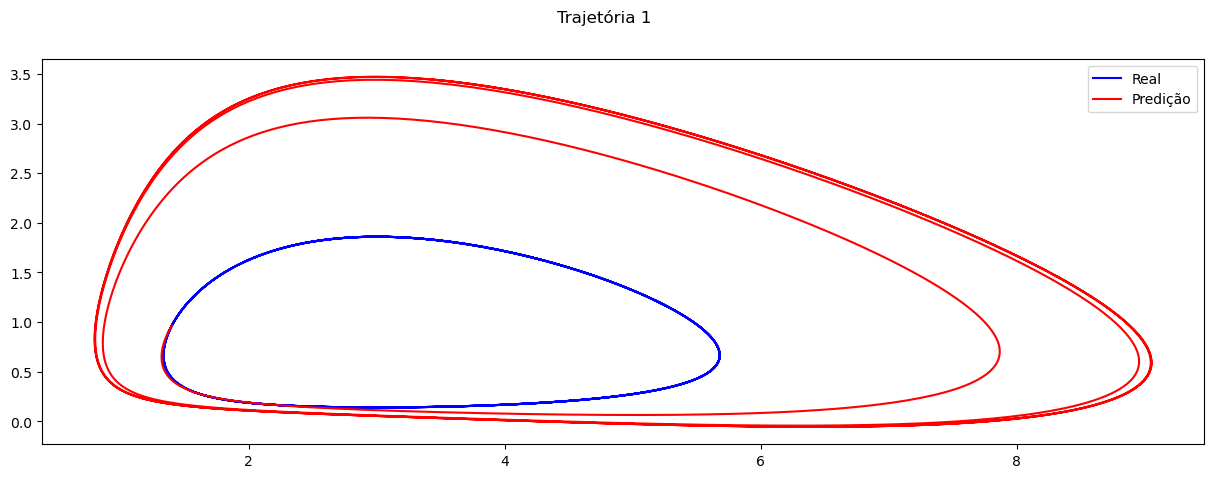

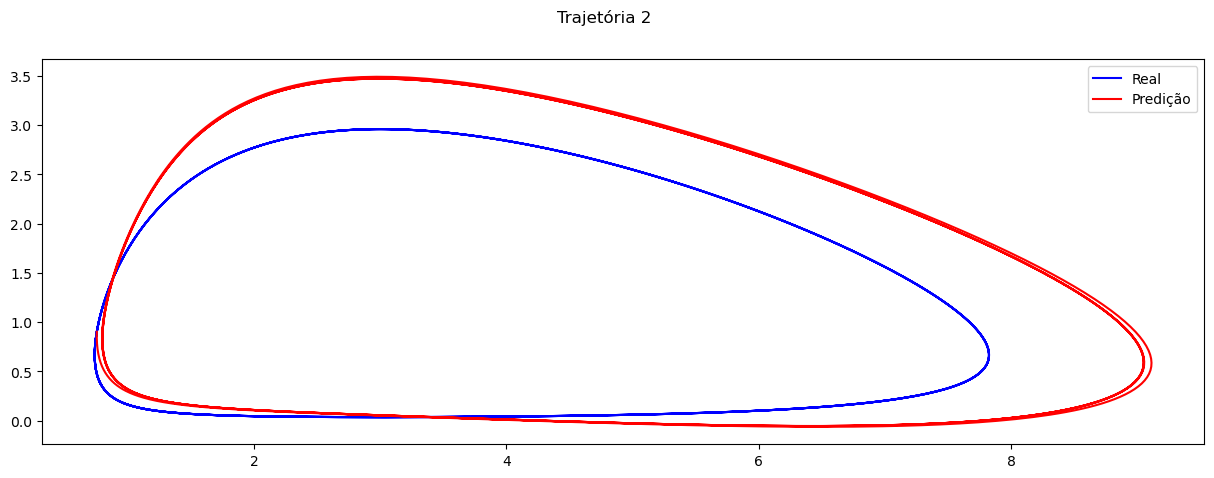

In [ ]:
from matplotlib import pyplot as plt
from IPython.display import display, HTML
components = ["x", "y"]
predictions = [predictedFirst, predictedSecond, predictedFourth]
networks = ["Primeira rede", "Segunda rede", "Quarta rede"]
for i, network in enumerate(networks):
    display(HTML(f"<h1 style='font-size: 64px'>{network}</h1>"), )
    for traj in range(3):
        figure = plt.figure(figsize=(15, 5))
        plt.plot(x_t_testing[traj, :, 0], x_t_testing[traj, :, 1], "b", label = "Real")
        plt.plot(predictions[i][traj, :, 0], predictions[i][traj, :, 1], "r", label = "Predição")
        plt.legend()
        figure.suptitle(f"Trajetória {traj}")
    plt.show()

# Modelo simples com espectro discreto

Importando bibliotecas

In [36]:
import keras
import numpy as np
from scipy import integrate

## Parâmetros da simulação e treinamento

Intervalo de integração

In [37]:
T = 20; dt = 0.01; t = np.arange(0, T + dt, dt)

Constantes do Sistema de EDOs

In [38]:
mu = -0.05; lambdaValue = -1.0

Definindo função que calcula o sistema de EDOs

In [39]:
def simple_spectrum(x1_x2, t0):
    x1, x2 = x1_x2
    return [mu * x1, lambdaValue * (x2 - x1 ** 2)]

Quantidade de sistemas utilizados no treinamento

In [40]:
n = 500

## Gerando dados de treinamento

n Valores iniciais aleatórios

In [41]:
x0 = 0.5 + 1.5 * np.random.random((n, 2))

Obtendo soluções dos n sistemas

In [42]:
x_t = np.asarray([integrate.odeint(simple_spectrum, x0_j, t) for x0_j in x0])

Separando input e output para treinamento

In [43]:
nn_input = np.zeros((n * (len(t) - 1), 2))
nn_output = np.zeros_like(nn_input)

for j in range(n):
    nn_input[j * (len(t) - 1) : (j + 1) * (len(t) - 1), :] = x_t[j, :-1, :]
    nn_output[j * (len(t) - 1) : (j + 1) * (len(t) - 1), :] = x_t[j, 1:, :]

## Modelando e treinando Rede(/s) Neural(/is)

Utilizaremos os mesmos quatro modelos de rede neural desenvolvidos para o sistema de Lotka-Volterra

In [44]:
netFirst = keras.models.Sequential()
netFirst.add(keras.layers.Dense(10, input_dim = 2, activation = "sigmoid"))
netFirst.add(keras.layers.Dense(10, activation = "relu"))
netFirst.add(keras.layers.Dense(2, activation = "linear"))
netFirst.compile(loss = "mse", optimizer = "adam")

In [45]:
netSecond = keras.models.Sequential()
netSecond.add(keras.layers.Dense(5, input_dim = 2, activation = "sigmoid"))
netSecond.add(keras.layers.Dense(5, activation = "relu"))
netSecond.add(keras.layers.Dense(2, activation = "linear"))
netSecond.compile(loss = "mse", optimizer = "adam")

In [46]:
netThird = keras.models.Sequential()
netThird.add(keras.layers.Dense(5, input_dim = 2, activation = "sigmoid"))
netThird.add(keras.layers.Dense(2, activation = "relu"))
netThird.compile(loss = "mse", optimizer = "adam")

In [47]:
netFourth = keras.models.Sequential()
netFourth.add(keras.layers.Dense(3, input_dim = 2, activation = "sigmoid"))
netFourth.add(keras.layers.Dense(4, activation = "relu"))
netFourth.add(keras.layers.Dense(2, activation = "linear"))
netFourth.compile(loss = "mse", optimizer = "adam")

Treinando as quatro redes neurais

In [48]:
historyFirst = netFirst.fit(nn_input, nn_output, epochs = 1000, batch_size = len(t) - 1)
historySecond = netSecond.fit(nn_input, nn_output, epochs = 1000, batch_size = len(t) - 1)
historyThird = netThird.fit(nn_input, nn_output, epochs = 1000, batch_size = len(t) - 1)
historyFourth = netFourth.fit(nn_input, nn_output, epochs= 1000, batch_size = len(t) - 1)

Epoch 1/1000
500/500 [==============================] - 1s 780us/step - loss: 0.1077
Epoch 2/1000
500/500 [==============================] - 0s 764us/step - loss: 0.0035
Epoch 3/1000
500/500 [==============================] - 0s 759us/step - loss: 0.0025
Epoch 4/1000
500/500 [==============================] - 0s 770us/step - loss: 0.0020
Epoch 5/1000
500/500 [==============================] - 0s 767us/step - loss: 0.0015
Epoch 6/1000
500/500 [==============================] - 0s 774us/step - loss: 0.0011
Epoch 7/1000
500/500 [==============================] - 0s 768us/step - loss: 6.3417e-04
Epoch 8/1000
500/500 [==============================] - 0s 773us/step - loss: 3.0304e-04
Epoch 9/1000
500/500 [==============================] - 0s 768us/step - loss: 1.3651e-04
Epoch 10/1000
500/500 [==============================] - 0s 777us/step - loss: 6.5022e-05
Epoch 11/1000
500/500 [==============================] - 0s 762us/step - loss: 2.9819e-05
Epoch 12/1000
500/500 [====================

Abaixo estão os gráficos com o histórico de *loss* para cada Rede Neural. Utilizaremos escala logarítmica devido à grande amplitude de valores.

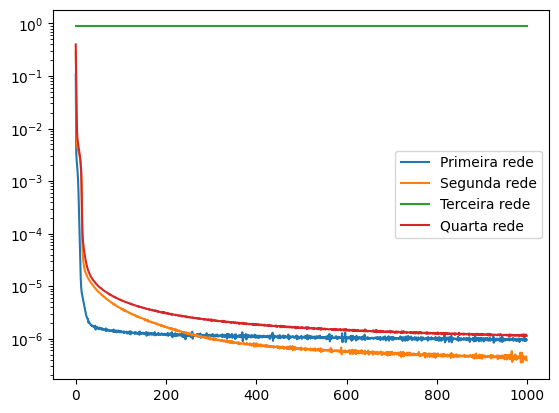

In [49]:
from matplotlib import pyplot as plt
plt.plot(historyFirst.history["loss"], label = "Primeira rede")
plt.plot(historySecond.history["loss"], label = "Segunda rede")
plt.plot(historyThird.history["loss"], label = "Terceira rede")
plt.plot(historyFourth.history["loss"], label = "Quarta rede")
plt.yscale("log")
plt.legend()
plt.show()

Todas as redes com exceção da terceira atingem convergência.

## Testando redes neurais treinadas

Iremos gerar 3 condições iniciais, obter o resultado via integração utilizando um método numérico de Runge-Kutta e depois iremos comparar com a predição gerada pelas 3 redes neurais adotadas (primeira, segunda e quarta).
As condições iniciais geradas vão fugir do padrão utilizado em treinamento, para avaliar a capacidade de generalização das redes.

In [50]:
x0_testing = 0.5 + 3.0 * np.random.random((3, 2))
x_t_testing = np.asarray([integrate.odeint(simple_spectrum, x0_j, t) for x0_j in x0_testing])
predictedFirst = np.zeros_like(x_t_testing) # Primeira rede
predictedSecond = np.zeros_like(x_t_testing) # Segunda rede
predictedFourth = np.zeros_like(x_t_testing) # Quarta rede
predictedFirst[:, 0, :] = x0_testing
predictedSecond[:, 0, :] = x0_testing
predictedFourth[:, 0, :] = x0_testing
for j in range(1, len(t)):
    predictedFirst[:, j, :] = netFirst.predict(predictedFirst[:, j - 1, :])
    predictedSecond[:, j, :] = netSecond.predict(predictedSecond[:, j - 1, :])
    predictedFourth[:, j, :] = netFourth.predict(predictedFourth[:, j - 1, :])

1/1 [==============================] - 0s 13ms/step


## Resultados do teste

Comparando o valor das componentes $x_1$ e $x_2$ para as 3 condições iniciais

### Gráfico componentes x tempo

<Figure size 640x480 with 0 Axes>

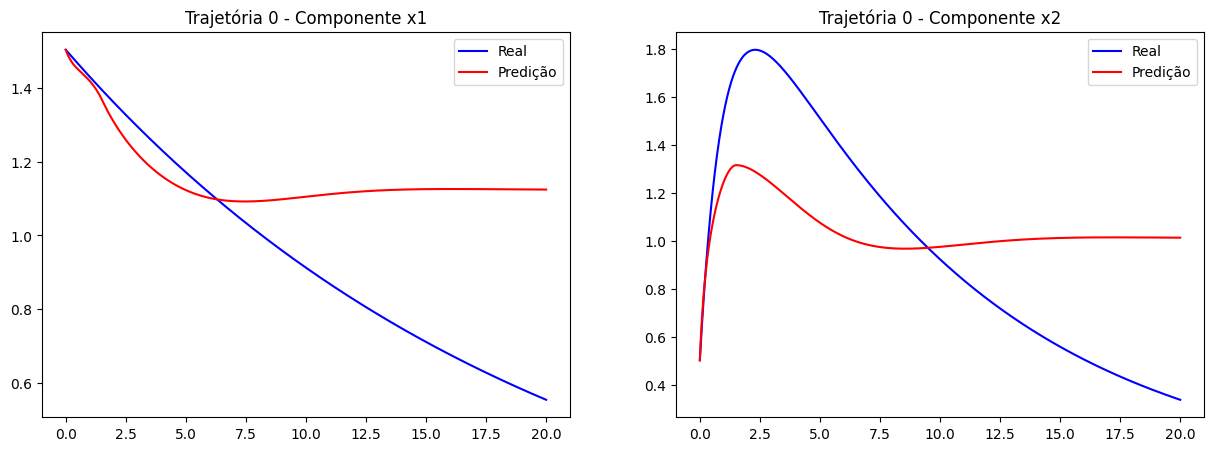

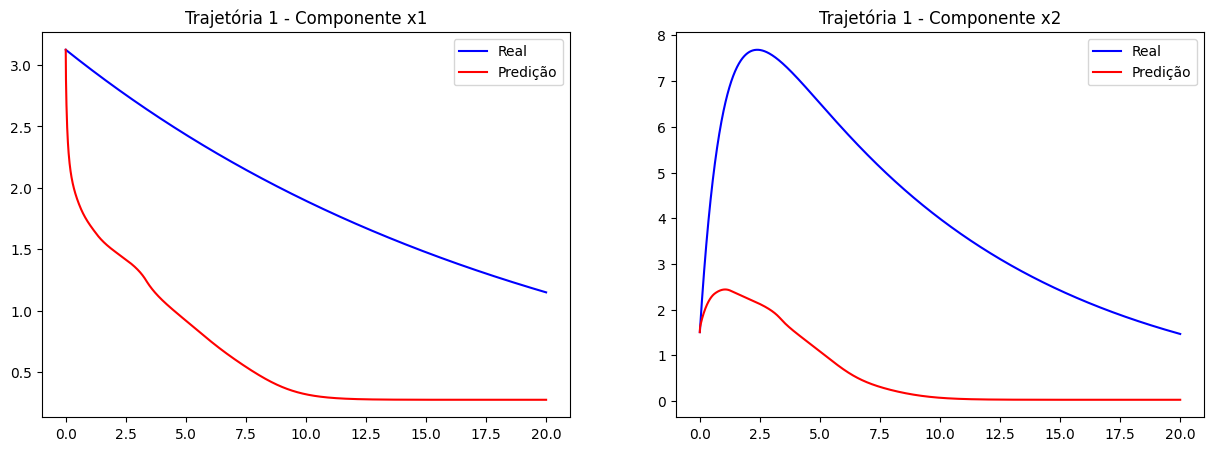

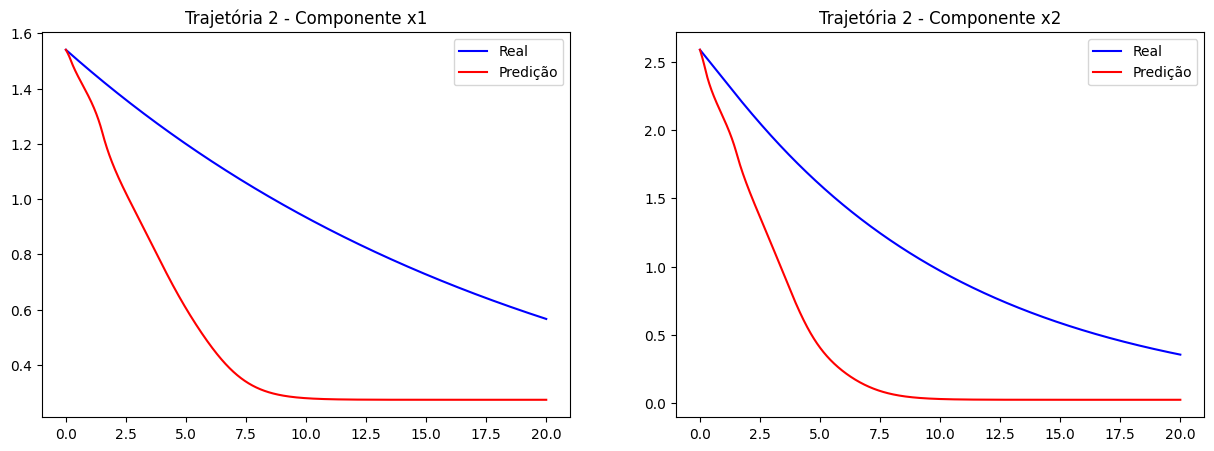

<Figure size 640x480 with 0 Axes>

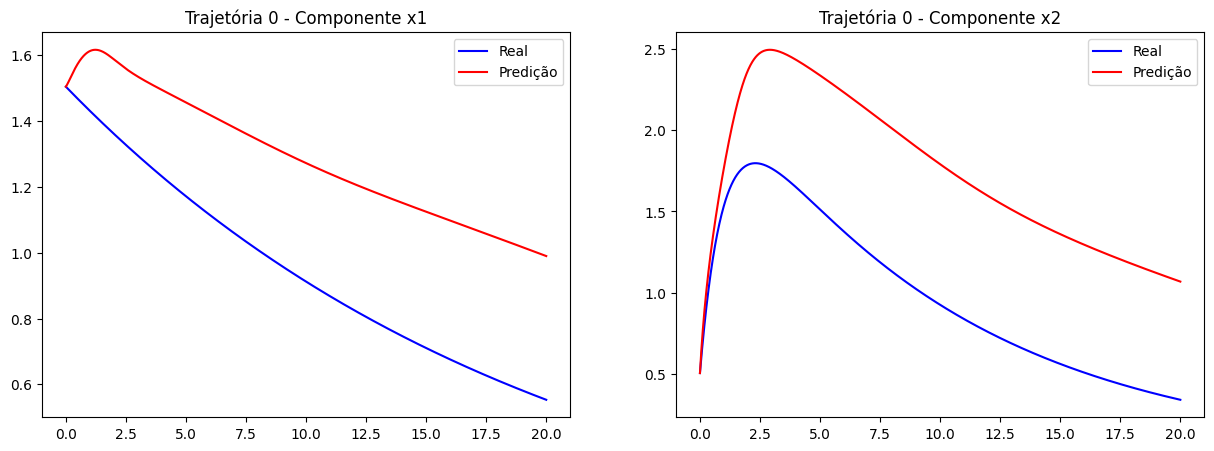

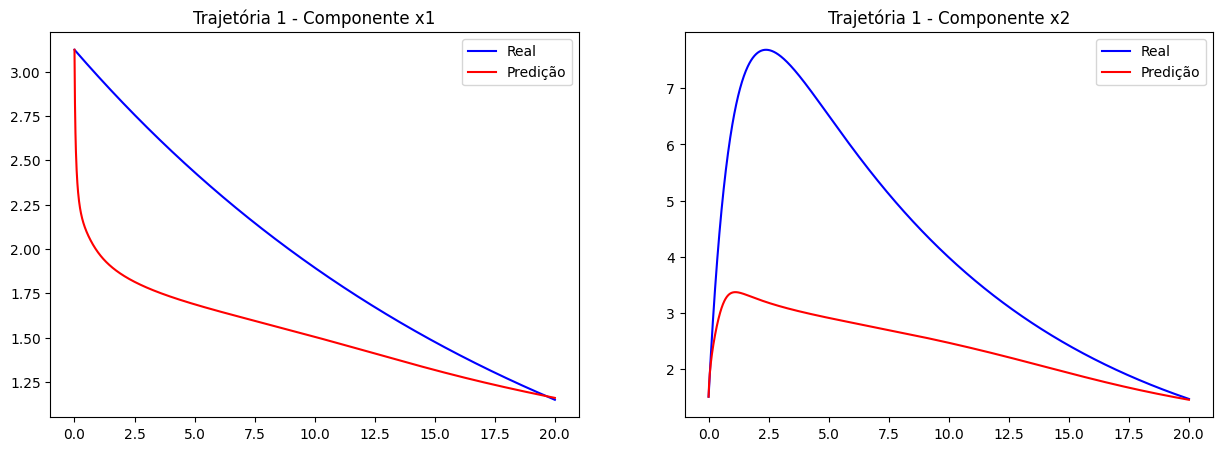

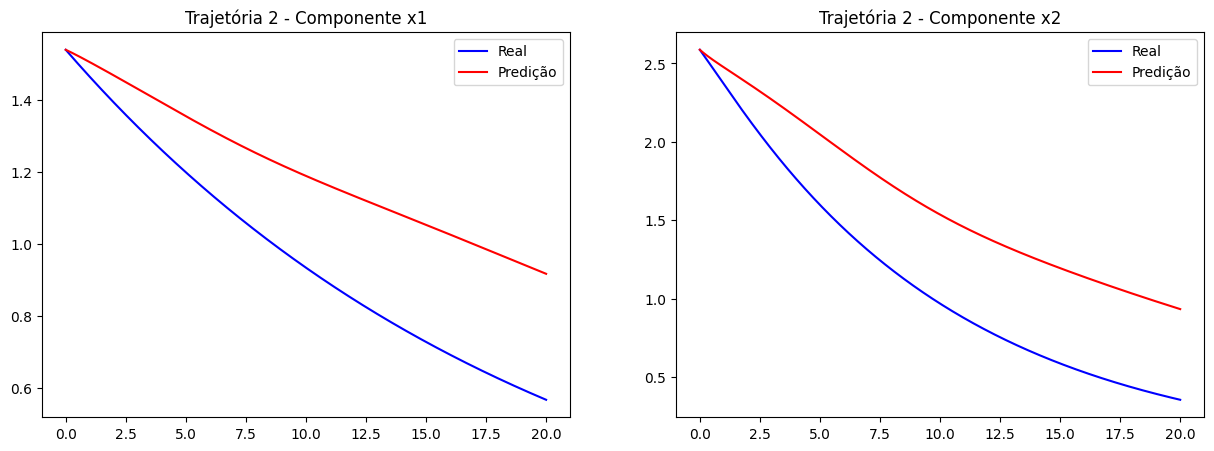

<Figure size 640x480 with 0 Axes>

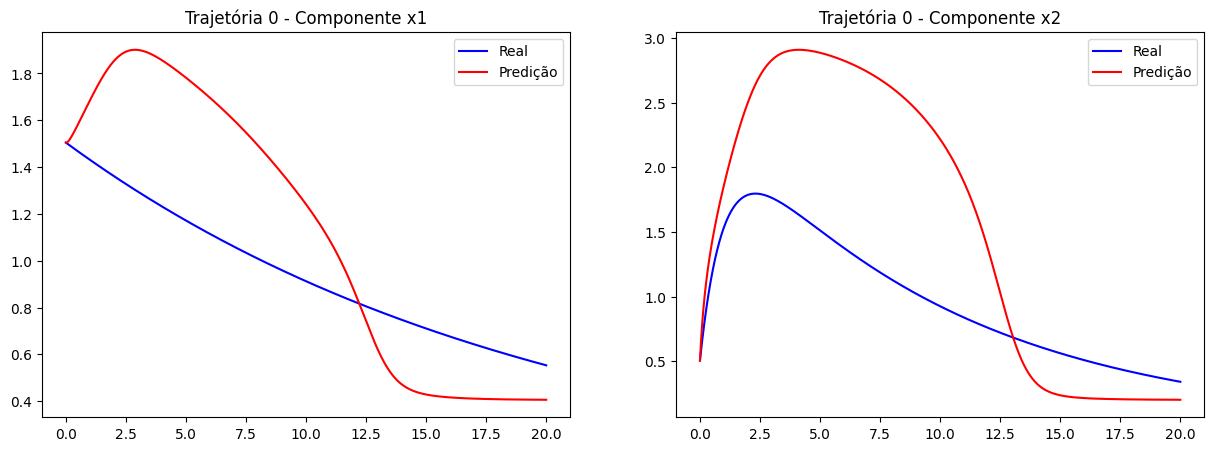

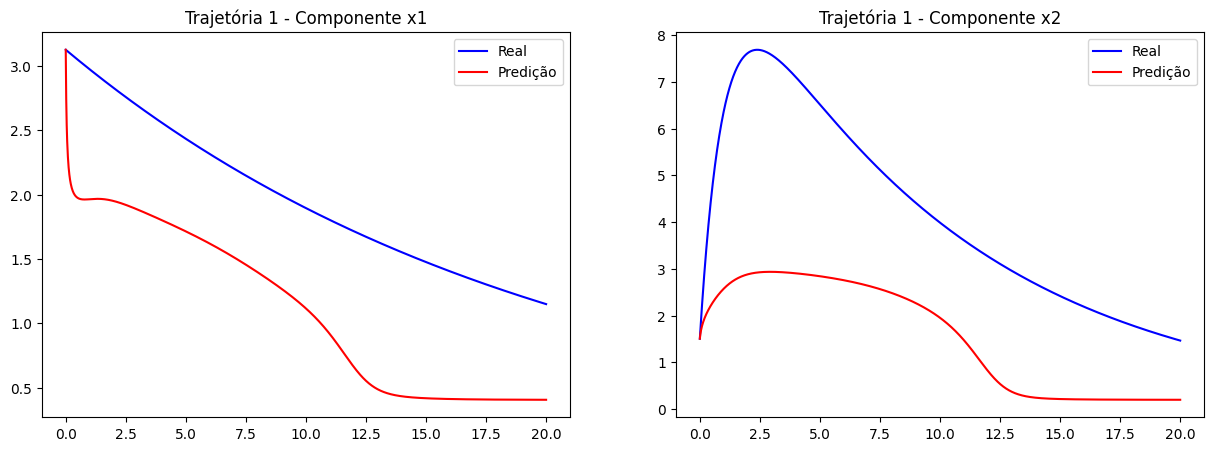

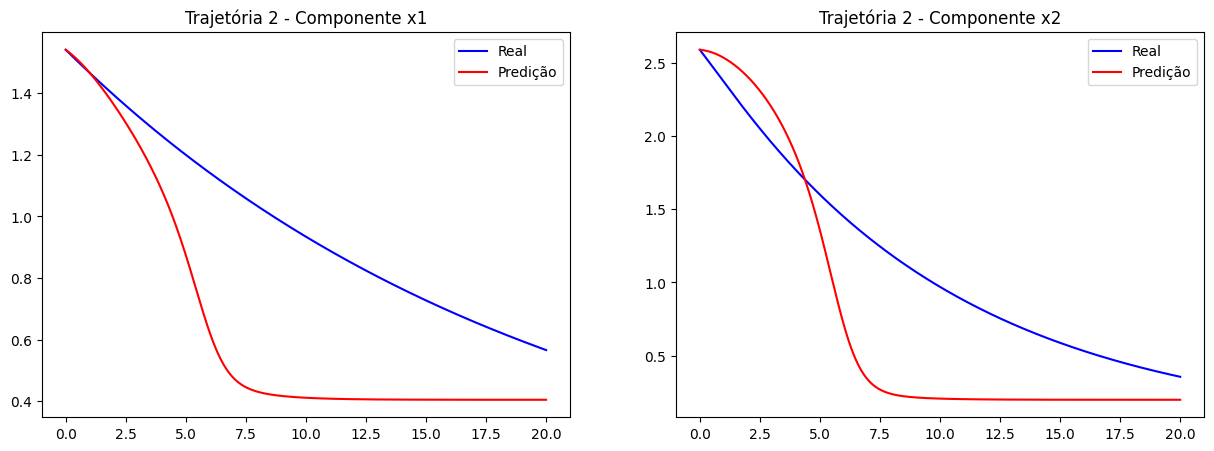

In [51]:
from matplotlib import pyplot as plt
from IPython.display import display, HTML
components = ["x1", "x2"]
predictions = [predictedFirst, predictedSecond, predictedFourth]
networks = ["Primeira rede", "Segunda rede", "Quarta rede"]
for i, network in enumerate(networks):
    display(HTML(f"<h1 style='font-size: 64px'>{network}</h1>"), )
    figure = plt.figure()
    for traj in range(3):
        _, axis = plt.subplots(1, 2, figsize = (15, 5))
        for j in range(2):
            axis[j].plot(t, x_t_testing[traj, :, j], "b", label = "Real")
            axis[j].plot(t, predictions[i][traj, :, j], "r", label = "Predição")
            axis[j].legend()
            axis[j].set_title(f"Trajetória {traj} - Componente {components[j]}")
    plt.show()


Ao comparar com os resultados obtidos para a equação de Lotka-Volterra, não obtivemos resultados tão bons.

## Guardando pesos das redes neurais treinadas

In [ ]:
netFirst.save("SimpleSpectrum_firstNetwork.h5")
netSecond.save("SimpleSpectrum_secondNetwork.h5")
netFourth.save("SimpleSpectrum_fourthNetwork.h5")

# Pêndulo

Importando bibliotecas

In [1]:
import keras
import numpy as np
from scipy import integrate

2023-07-02 22:37:44.907098: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-02 22:37:45.312935: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-02 22:37:45.315411: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-02 22:37:46.715963: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Parâmetros da simulação e treinamento

Intervalo de integração. Experimentaremos um valor menor para $\delta_t$

In [2]:
T = 20; dt = 0.005; t = np.arange(0, T + dt, dt)

Definindo função que calcula o sistema de EDOs

In [3]:
def pendulum(x1_x2, t0):
    x1, x2 = x1_x2
    return [x2, - np.sin(x1)]

Quantidade de sistemas utilizados no treinamento. Dessa vez, dobraremos a quantidade de exemplos utilizados para treinamento, para verificar a diferença que isso fará no resultado final.

In [4]:
n = 1000

## Gerando dados de treinamento

n Valores iniciais aleatórios

In [5]:
x0 = -1 + 2 * np.random.random((n, 2))
# Pêndulo começa inclinado para um dos lados, com velocidade inicial nula
# Velocidade é a derivada da posição, logo x2 inicial deve ser 0
x0[:, 1] = 0

Obtendo soluções dos n sistemas

In [6]:
x_t = np.asarray([integrate.odeint(pendulum, x0_j, t) for x0_j in x0])

Separando input e output para treinamento

In [7]:
nn_input = np.zeros((n * (len(t) - 1), 2))
nn_output = np.zeros_like(nn_input)

for j in range(n):
    nn_input[j * (len(t) - 1) : (j + 1) * (len(t) - 1), :] = x_t[j, :-1, :]
    nn_output[j * (len(t) - 1) : (j + 1) * (len(t) - 1), :] = x_t[j, 1:, :]

## Modelando e treinando Rede(/s) Neural(/is)

Dessa vez, iremos alterar a rede com uma camada a menos (que falhou em atingir convergência) para aumentar o número de neurônios contida na mesma.

In [8]:
netFirst = keras.models.Sequential()
netFirst.add(keras.layers.Dense(10, input_dim = 2, activation = "sigmoid"))
netFirst.add(keras.layers.Dense(10, activation = "relu"))
netFirst.add(keras.layers.Dense(2, activation = "linear"))
netFirst.compile(loss = "mse", optimizer = "adam")

2023-07-02 22:38:05.135722: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-02 22:38:05.136378: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [9]:
netSecond = keras.models.Sequential()
netSecond.add(keras.layers.Dense(5, input_dim = 2, activation = "sigmoid"))
netSecond.add(keras.layers.Dense(5, activation = "relu"))
netSecond.add(keras.layers.Dense(2, activation = "linear"))
netSecond.compile(loss = "mse", optimizer = "adam")

In [10]:
netThird = keras.models.Sequential()
netThird.add(keras.layers.Dense(10, input_dim = 2, activation = "sigmoid"))
netThird.add(keras.layers.Dense(2, activation = "relu"))
netThird.compile(loss = "mse", optimizer = "adam")

Treinando as três redes neurais e salvando após cada treinamento.

In [12]:
historyFirst = netFirst.fit(nn_input, nn_output, epochs = 1000, batch_size = len(t) - 1)
netFirst.save("Pendulum_firstNetwork.h5")
historySecond = netSecond.fit(nn_input, nn_output, epochs = 1000, batch_size = len(t) - 1)
netSecond.save("Pendulum_secondNetwork.h5")
historyThird = netThird.fit(nn_input, nn_output, epochs = 1000, batch_size = len(t) - 1)
netThird.save("Pendulum_thirdNetwork.h5")

Epoch 1/1000
1000/1000 [==============================] - 1s 887us/step - loss: 1.6340e-06
Epoch 2/1000
1000/1000 [==============================] - 1s 885us/step - loss: 1.6345e-06
Epoch 3/1000
1000/1000 [==============================] - 1s 912us/step - loss: 1.6122e-06
Epoch 4/1000
1000/1000 [==============================] - 1s 879us/step - loss: 1.5896e-06
Epoch 5/1000
1000/1000 [==============================] - 1s 887us/step - loss: 1.6232e-06
Epoch 6/1000
1000/1000 [==============================] - 1s 881us/step - loss: 1.6056e-06
Epoch 7/1000
1000/1000 [==============================] - 1s 883us/step - loss: 1.5628e-06
Epoch 8/1000
1000/1000 [==============================] - 1s 879us/step - loss: 1.5899e-06
Epoch 9/1000
1000/1000 [==============================] - 1s 888us/step - loss: 1.5670e-06
Epoch 10/1000
1000/1000 [==============================] - 1s 887us/step - loss: 1.5408e-06
Epoch 11/1000
1000/1000 [==============================] - 1s 896us/step - loss: 1.5710e-

KeyboardInterrupt: 

**Nas 100 primeiras *epochs*, a terceira rede apresentou uma tendência de não convergir. Como cada treinamento está tomando aproximadamente 15 minutos, optei por não prosseguir treinando a terceira rede, assumindo que a mesma não irá convergir.**

Mesmo aumentando o número de neurônios da terceira rede, ela não apresenta um resultado satisfatório. Portanto, vamos abandoná-la de vez e pensar em outras alternativas. No caso, criaremos uma quarta rede que diminui o número de neurônios da segunda rede, melhor rede até então. Isso foi feito nos caso de Lotka-Volterra e Espectro Simples com uma rede tendo [3, 4] neurônios nas camadas ocultas. Dessa vez, utilizaremos [4, 4], o loss final deve ser ligeiramente menor. Também trocaremos a função de ativação *rectified linear unit* pela *exponential linear unit*, para investigar a diferença no comportamento.

In [13]:
netFourth = keras.models.Sequential()
netFourth.add(keras.layers.Dense(4, input_dim = 2, activation = "sigmoid"))
netFourth.add(keras.layers.Dense(4, activation = "elu"))
netFourth.add(keras.layers.Dense(2, activation = "linear"))
netFourth.compile(loss = "mse", optimizer = "adam")

Treinando essa nova rede...

In [14]:
historyFourth = netFourth.fit(nn_input, nn_output, epochs = 1000, batch_size = len(t) - 1)

Epoch 1/1000


1000/1000 [==============================] - 1s 942us/step - loss: 0.1802
Epoch 2/1000
1000/1000 [==============================] - 1s 947us/step - loss: 0.0135
Epoch 3/1000
1000/1000 [==============================] - 1s 938us/step - loss: 0.0012
Epoch 4/1000
1000/1000 [==============================] - 1s 932us/step - loss: 7.7030e-04
Epoch 5/1000
1000/1000 [==============================] - 1s 916us/step - loss: 4.9894e-04
Epoch 6/1000
1000/1000 [==============================] - 1s 919us/step - loss: 3.1089e-04
Epoch 7/1000
1000/1000 [==============================] - 1s 915us/step - loss: 1.9587e-04
Epoch 8/1000
1000/1000 [==============================] - 1s 934us/step - loss: 1.3011e-04
Epoch 9/1000
1000/1000 [==============================] - 1s 907us/step - loss: 8.6715e-05
Epoch 10/1000
1000/1000 [==============================] - 1s 911us/step - loss: 5.6323e-05
Epoch 11/1000
1000/1000 [==============================] - 1s 920us/step - loss: 3.6948e-05
Epoch 12/1000
1000/100

Salvando modelo

In [15]:
netFourth.save("Pendulum_fourthNetwork.h5")

Resultado do treinamento

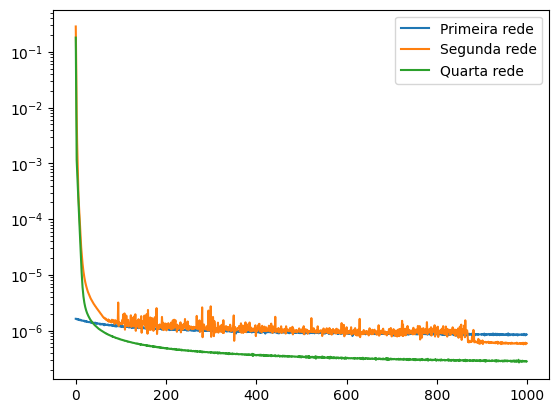

In [16]:
from matplotlib import pyplot as plt
plt.plot(historyFirst.history["loss"], label = "Primeira rede")
plt.plot(historySecond.history["loss"], label = "Segunda rede")
plt.plot(historyFourth.history["loss"], label = "Quarta rede")
plt.yscale("log")
plt.legend()
plt.show()

A segunda rede apresentou um comportamento estranho, mas estabilizou ao fim do treinamento, vamos verificar se algum efeito desse comportamento pode ser observado nos testes feitos a seguir...

## Testando redes neurais treinadas

Dessa vez, utilizaremos mais de 3 condições iniciais para testar as redes treinadas. Também utilizaremos uma *seed* pré-definida para garantir que os resultados são replicáveis. Utilizaremos 6 condições iniciais.

In [18]:
np.random.seed(196883) # Easter Egg
x0_testing = 2.0 * np.random.random((6, 2)) # Condições iniciais podem fugir do padrão de treinamento
x0_testing[:, 1] = 0.5 * np.random.random((6,)) # Velocidade inicial não nula
x_t_testing = np.asarray([integrate.odeint(pendulum, x0_j, t) for x0_j in x0_testing])
predictedFirst = np.zeros_like(x_t_testing) # Primeira rede
predictedSecond = np.zeros_like(x_t_testing) # Segunda rede
predictedFourth = np.zeros_like(x_t_testing) # Quarta rede
predictedFirst[:, 0, :] = x0_testing
predictedSecond[:, 0, :] = x0_testing
predictedFourth[:, 0, :] = x0_testing
for j in range(1, len(t)):
    predictedFirst[:, j, :] = netFirst.predict(predictedFirst[:, j - 1, :])
    predictedSecond[:, j, :] = netSecond.predict(predictedSecond[:, j - 1, :])
    predictedFourth[:, j, :] = netFourth.predict(predictedFourth[:, j - 1, :])

1/1 [==============================] - 0s 14ms/step


## Resultados do teste

Comparando o valor das componentes $x_1$ e $x_2$ para as 6 condições iniciais

### Gráfico componentes x tempo

<Figure size 640x480 with 0 Axes>

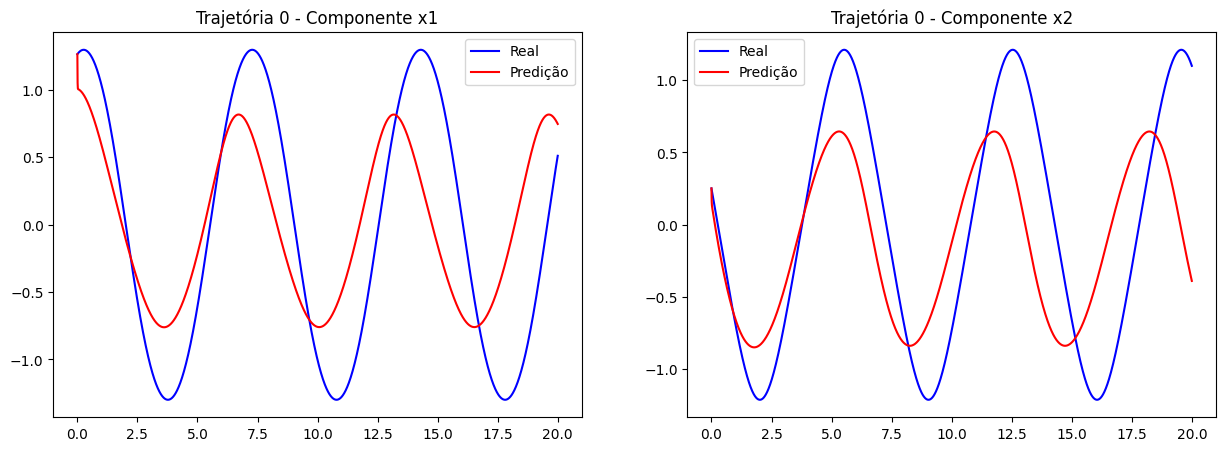

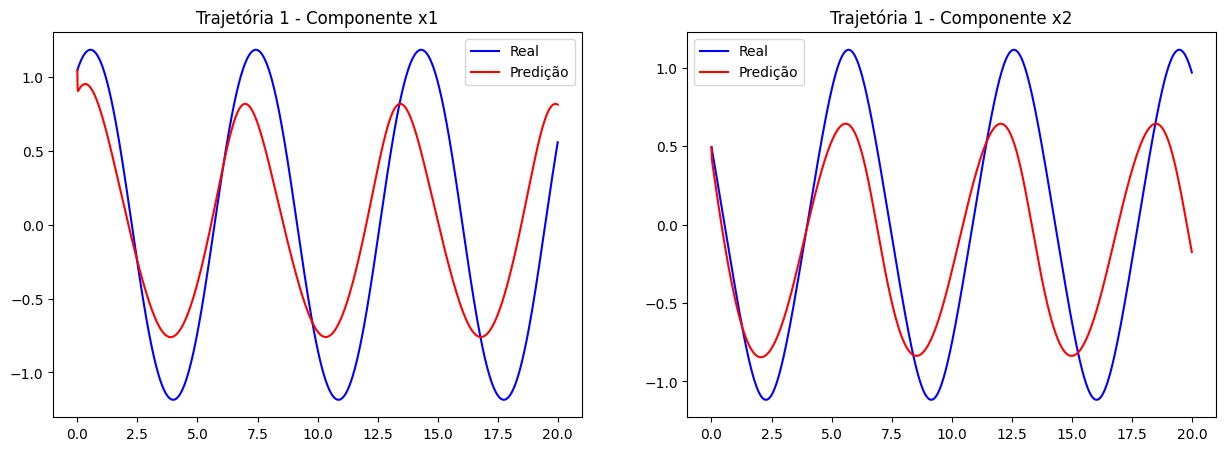

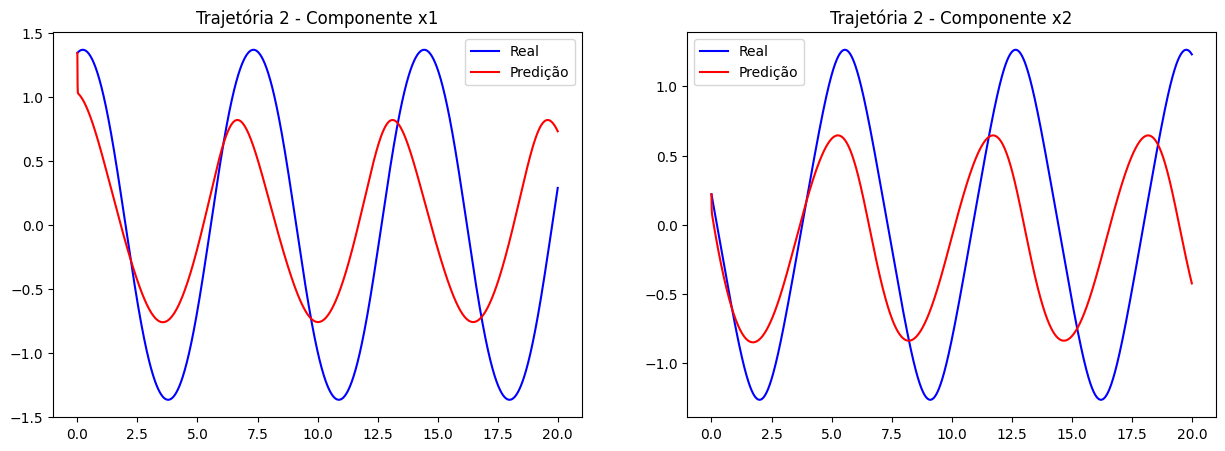

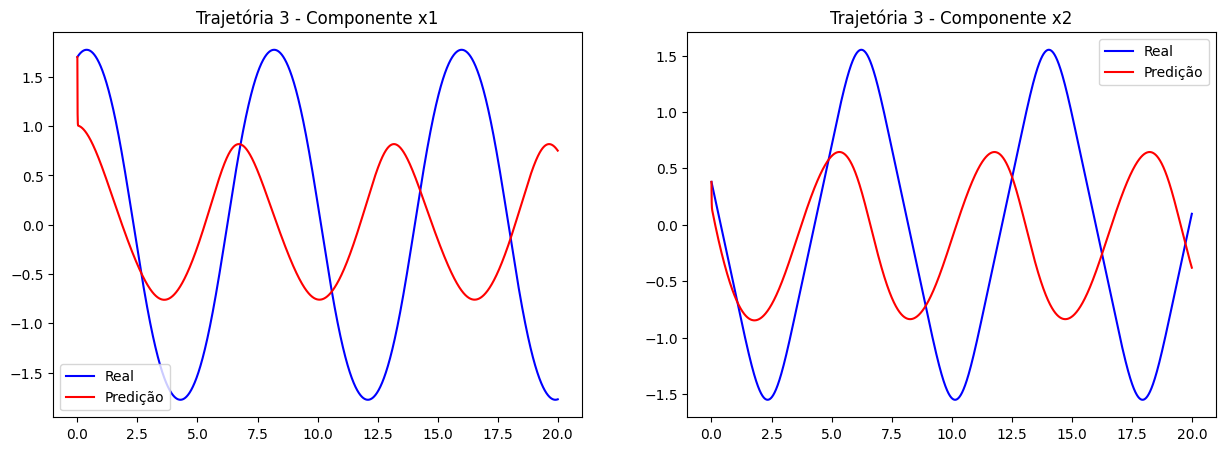

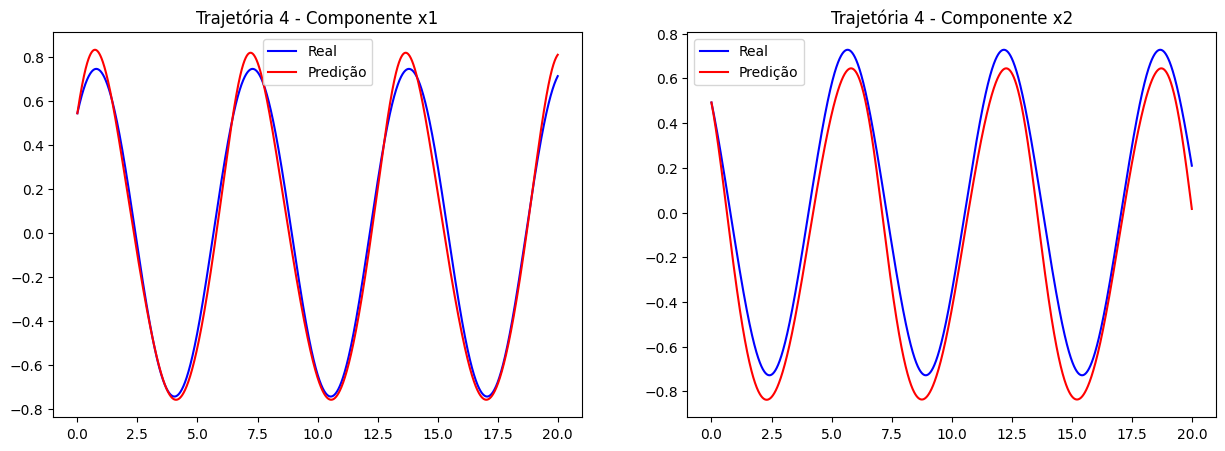

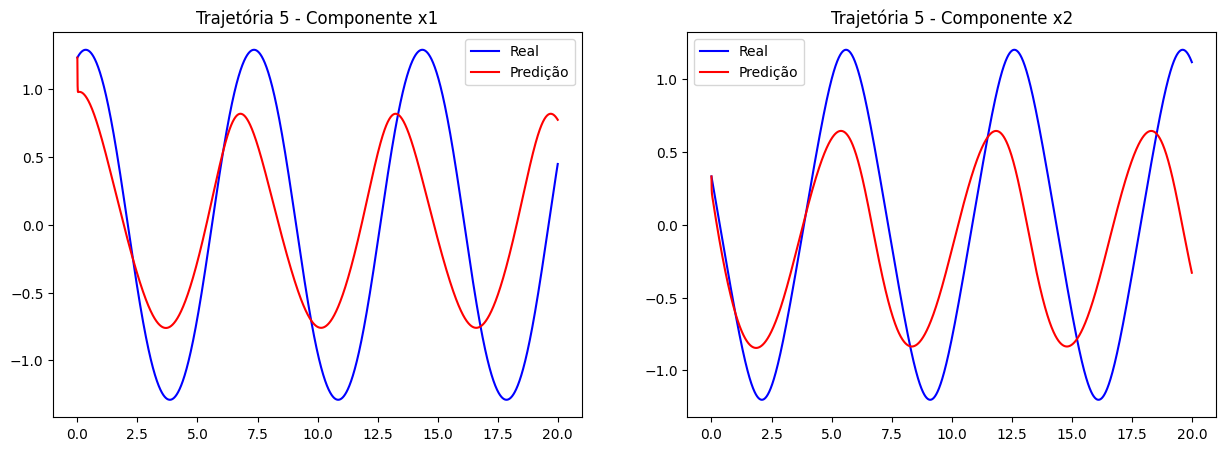

<Figure size 640x480 with 0 Axes>

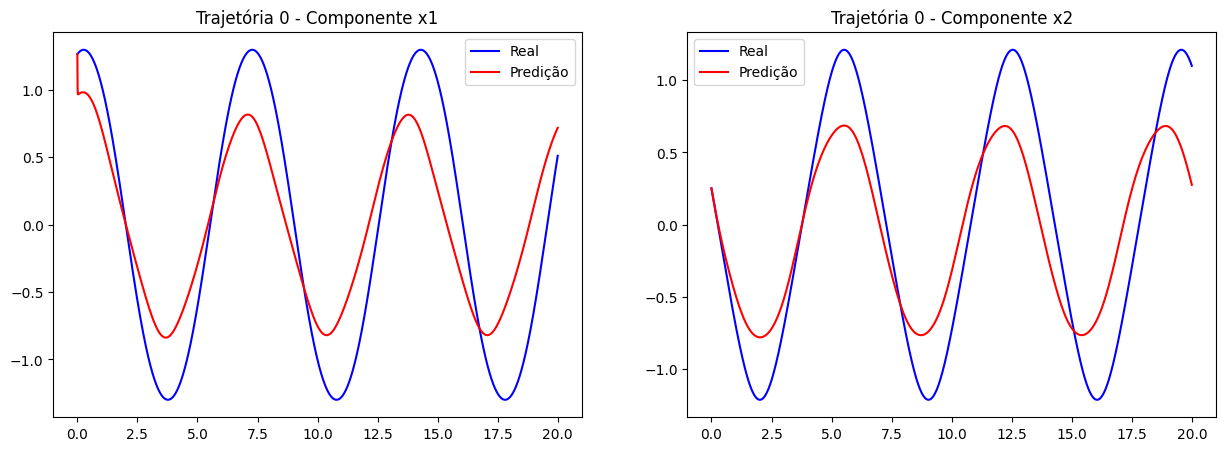

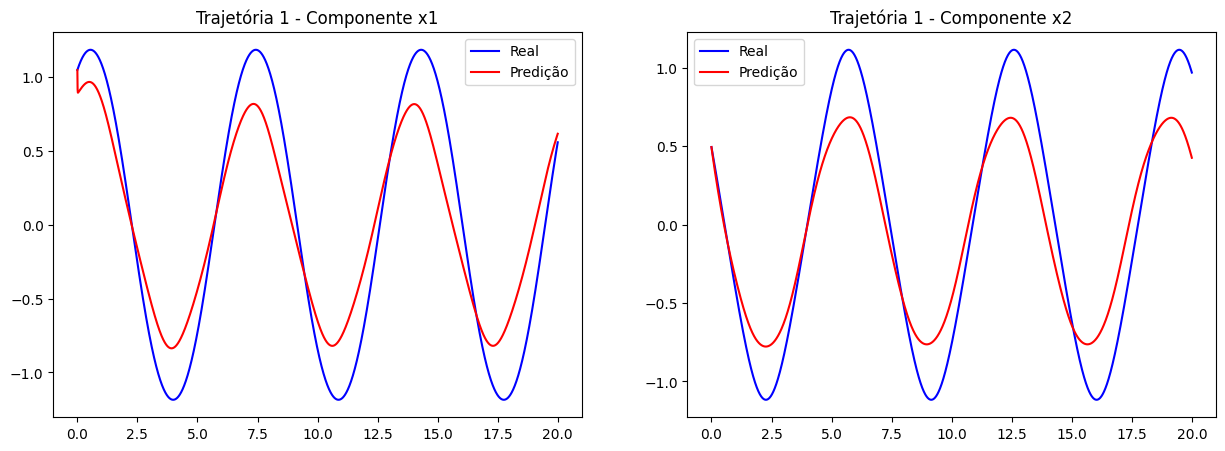

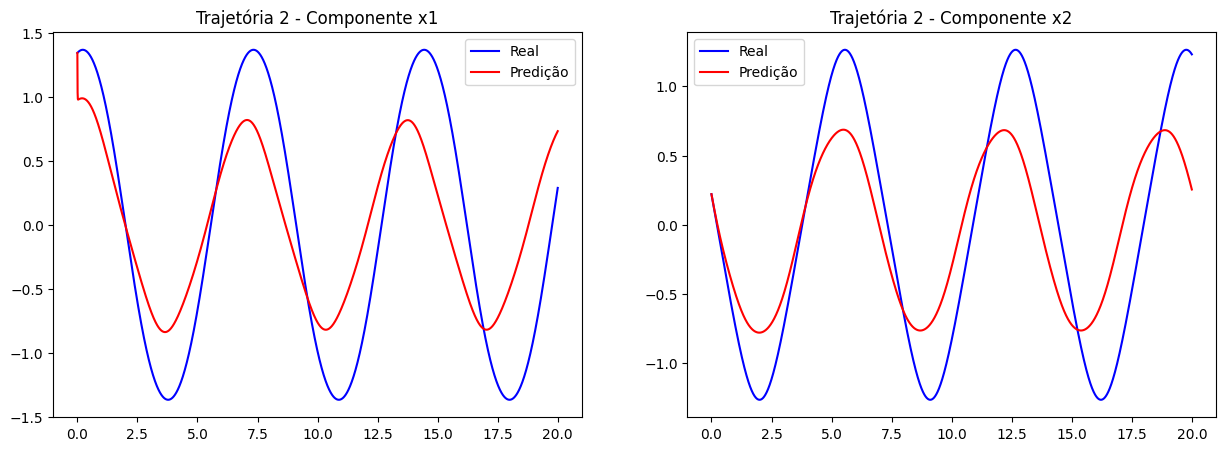

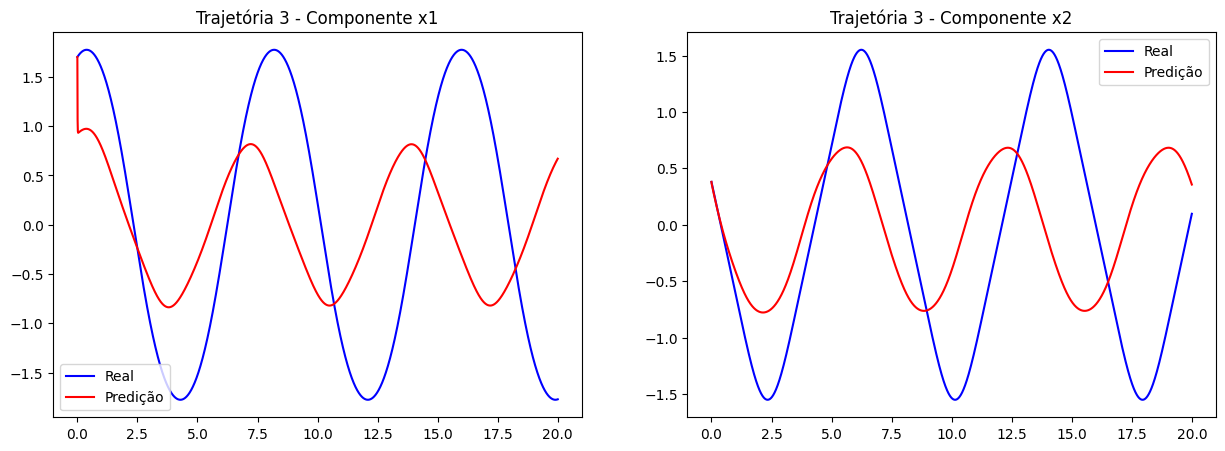

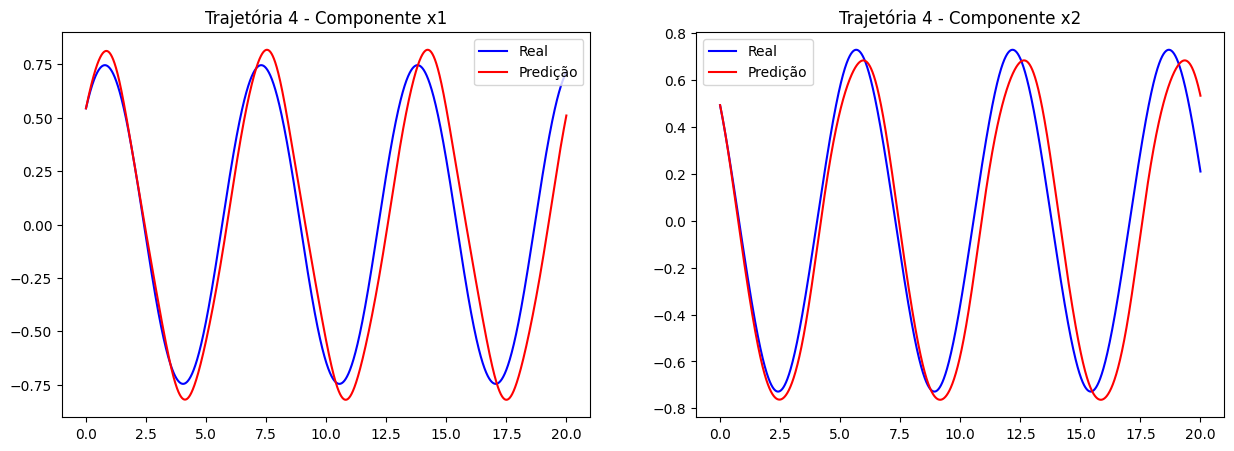

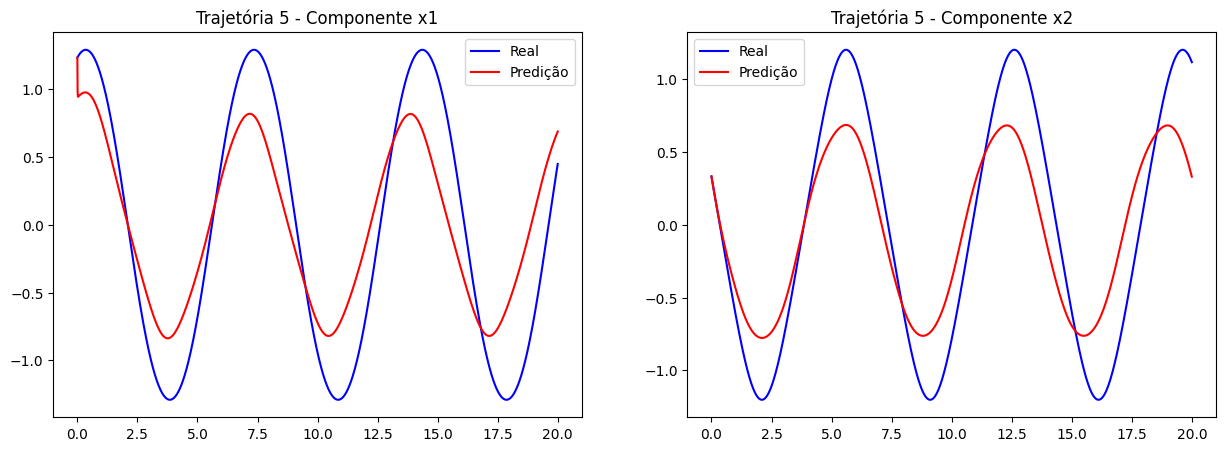

<Figure size 640x480 with 0 Axes>

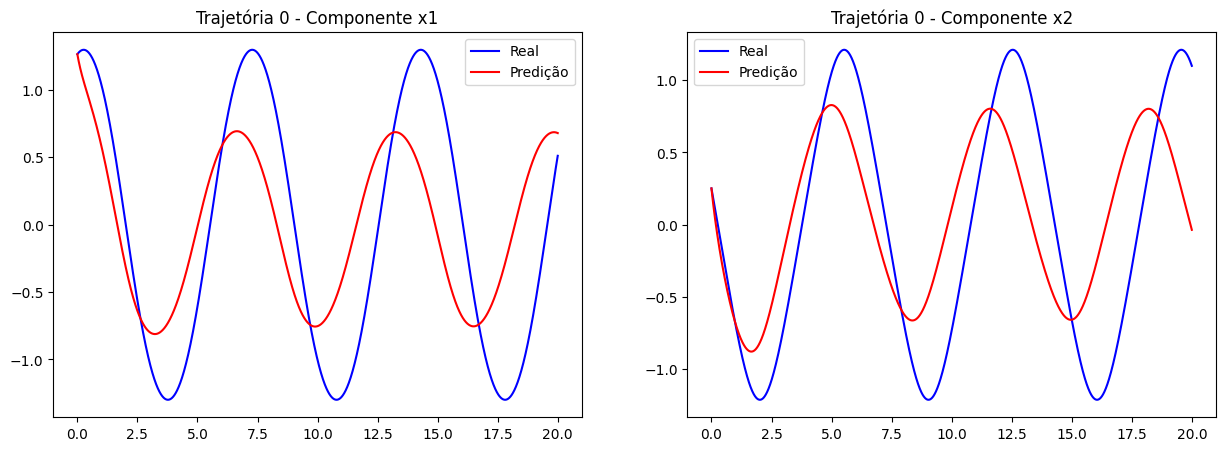

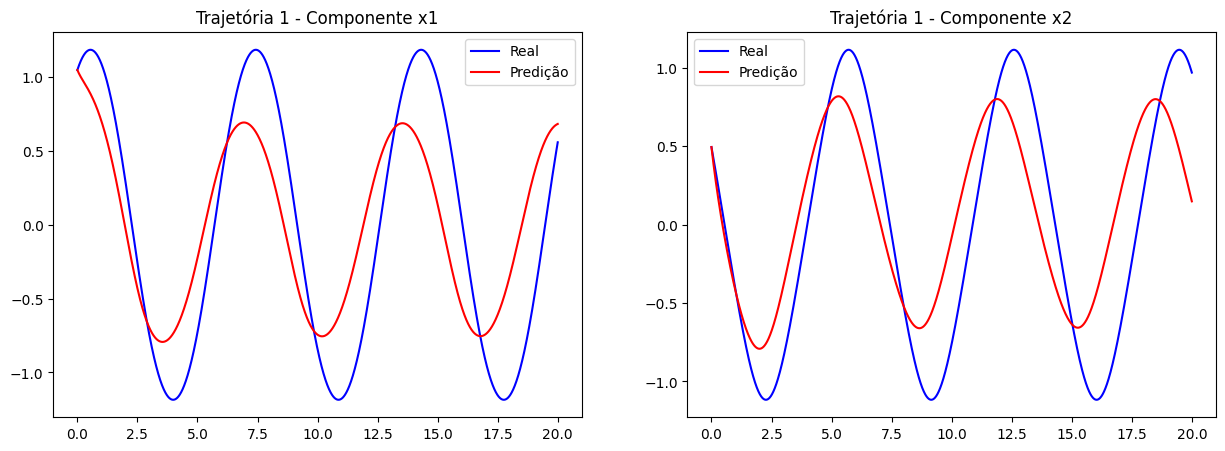

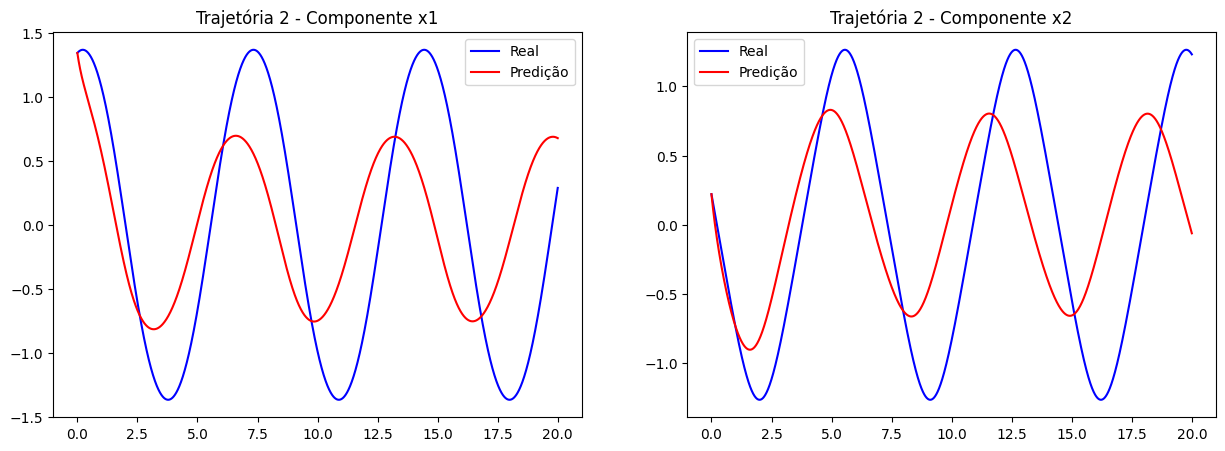

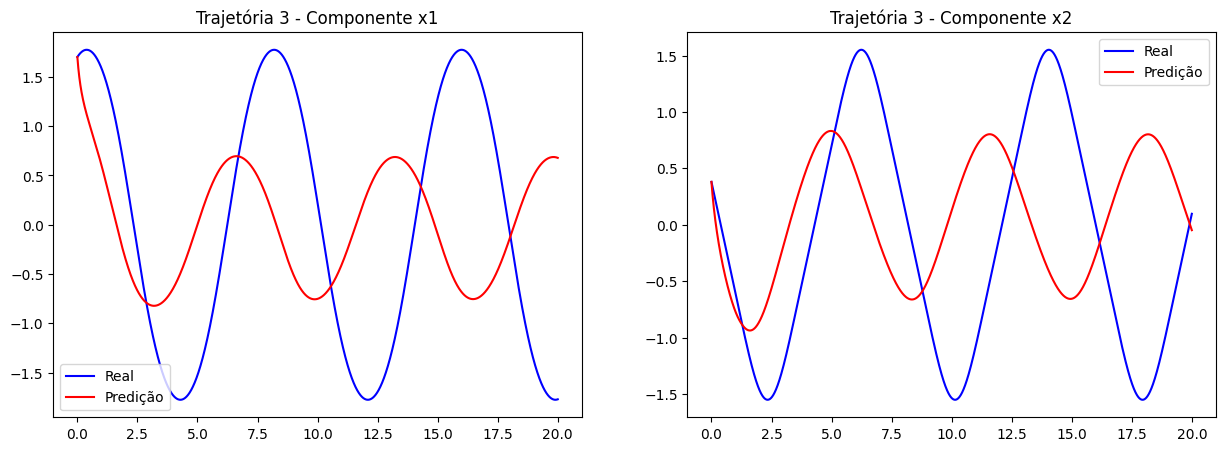

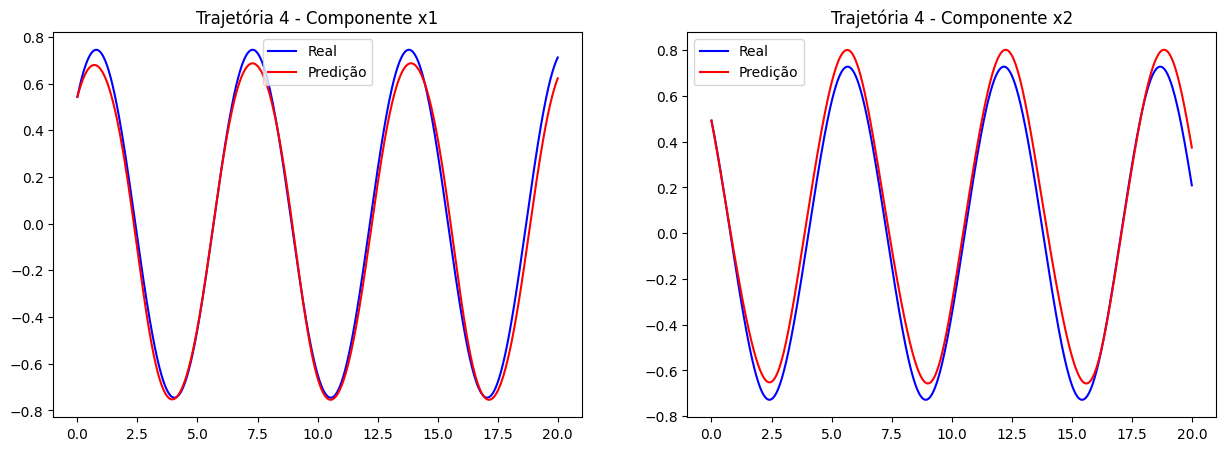

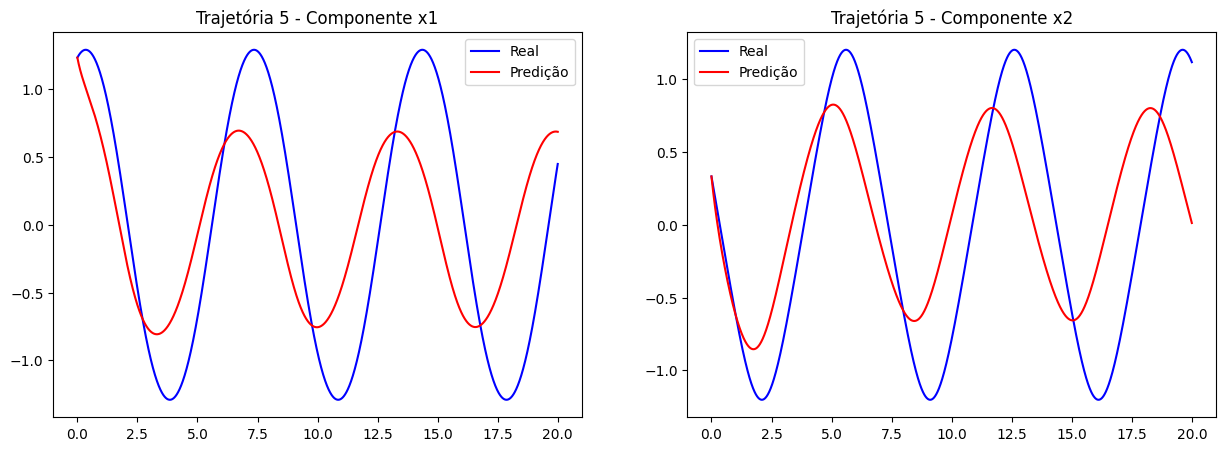

In [19]:
from matplotlib import pyplot as plt
from IPython.display import display, HTML
components = ["x1", "x2"]
predictions = [predictedFirst, predictedSecond, predictedFourth]
networks = ["Primeira rede", "Segunda rede", "Quarta rede"]
for i, network in enumerate(networks):
    display(HTML(f"<h1 style='font-size: 64px'>{network}</h1>"), )
    figure = plt.figure()
    for traj in range(6):
        _, axis = plt.subplots(1, 2, figsize = (15, 5))
        for j in range(2):
            axis[j].plot(t, x_t_testing[traj, :, j], "b", label = "Real")
            axis[j].plot(t, predictions[i][traj, :, j], "r", label = "Predição")
            axis[j].legend()
            axis[j].set_title(f"Trajetória {traj} - Componente {components[j]}")
    plt.show()


Os resultados obtidos são bem parecidos para todas as redes, tendo a segunda rede se saído melhor no geral. Todas as redes apresentaram um ótimo desempenho para a trajetória 4, pois é a que mais se assemelha com os casos de treino utilizados:

In [22]:
print(x0_testing[4,:])

[0.54338264 0.49210265]


Comparando com o restante:

In [23]:
print(x0_testing)

[[1.26649229 0.25154715]
 [1.04799535 0.49616092]
 [1.34209143 0.22095564]
 [1.70218498 0.38036698]
 [0.54338264 0.49210265]
 [1.23258174 0.3322172 ]]


Os outros valores iniciais fogem do intervalo de [-1, 1]